In [1]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import collections
from functools import partial
from os.path import expanduser
from tqdm import tqdm

from surround.image_processing import *
from surround.data_handling import *
from surround.efficient_coding import *
from aesthetics.plotting import *
from surround.modeling import gaussian, difference_of_gaussians

import pyret.filtertools as ft
from sklearn.decomposition import PCA
from scipy.stats import sem
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")
/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'interactive', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))
/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'timezone', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))
/home/lane/.l

Changes from previous versions:
- Constrain spacing by photoreceptor spacing
- Constrain width by visual field of salamander retina  
- Constrain output power instead of output variance

In [2]:
microns_per_degree = 50.0 # depends on species; this is for salamander
photoreceptor_width = 10.0/microns_per_degree # salamander photoreceptors have width of 10-20 microns
retina_width = 4000.0/microns_per_degree # salamander retina is about 4 mm
frequency_spacing = 1./retina_width # this is the lowest non-DC frequency we can estimate
highest_frequency = 0.5/photoreceptor_width # this is the highest frequency we can estimate (Nyquist freq.)

N = retina_width//photoreceptor_width
freqs = np.linspace(0, highest_frequency, N//2 + 1)
space = np.concatenate([np.linspace(-0.5*retina_width, 0, N//2 + 1)[:-1], np.linspace(0, 0.5*retina_width, N//2 + 1)])

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


### Load receptive fields

In [3]:
# These are loaded as (space, receptive) field tuples
cells = {}
cells['ganglion'] = load_ganglion_cells(space_mode='peak')
cells['bipolar'] = load_bipolar_cells(space_mode='peak')
cells['amacrine'] = load_amacrine_cells(space_mode='peak')
cells['horizontal'] = load_horizontal_cells(space_mode='peak')

In [4]:
receptive_fields = collections.defaultdict(list)
for c in cells.keys():
    for s, rf in cells[c]:
        this_cell_interp = interp1d(s, rf, kind='slinear', bounds_error=False, fill_value=[0])
        receptive_fields[c].append(this_cell_interp(space))
        
average_ganglion_rf = np.mean(receptive_fields['ganglion'], axis=0)

### Compute projective fields

In [5]:
horz_pfs_full = get_horizontal_projective_field(conv_mode='full')
horz_pfs_same = get_horizontal_projective_field(conv_mode='same')
ama_pfs_full = get_amacrine_projective_field(conv_mode='full')
ama_pfs_same = get_amacrine_projective_field(conv_mode='same')

space_h_full, horz_pf_full, horz_sem_full = get_mean(horz_pfs_full)
space_h_same, horz_pf_same, horz_sem_same = get_mean(horz_pfs_same)
space_a_full, ama_pf_full, ama_sem_full = get_mean(ama_pfs_full)
space_a_same, ama_pf_same, ama_sem_same = get_mean(ama_pfs_same)

In [6]:
horz_pf_interp = interp1d(space_h_full, horz_pf_full, kind='slinear', bounds_error=False, fill_value=[0])
ama_pf_interp = interp1d(space_a_full, ama_pf_full, kind='slinear', bounds_error=False, fill_value=[0])

horz_pf = horz_pf_interp(space)
ama_pf = ama_pf_interp(space)

### Signal

In [ ]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
im_path     = expanduser('~/data/images/Tkacik/cd01A')
num_images  = 100
patch_size  = None
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing     = 1./pixelsToDeg # number of degree spacing between pixels
normalize   = 'divisive'
contrast    = 0.35
patches     = load_images(im_path, num_images, patch_size, square=True, 
                          normalize=normalize, effective_contrast=contrast)
signal_amps, signal_freqs, signal_sem = averageAmplitudeSpectrum2d(patches, spacing=spacing)

Only 70 files in directory.


In [ ]:
def func(x, a, b):
    return a/(x**b) # adding a constant tends to make moreSpectra have negative numbers

popt_signal, pcov  = curve_fit(func, signal_freqs[1:], signal_amps[1:])
print(popt_signal)
signal = func(freqs, *popt_signal)
signal[0] = np.sqrt(np.sum(signal[1:]))

### Noise  
Note that the amplitude of the average_ganglion_fft will change the SNR. As the amplitude $\rightarrow \infty$, we get $$\rm{SNR} \rightarrow \frac{\sum (\rm{filter}_{1:f} \times \rm{signal}_{1:f})^2}{\sum (\rm{filter}_{1:f} \times N_{\rm{in}})^2}$$.  

Since the scale of the ganglion fft is arbitrary, we can look at the SNR in this limit.

In [ ]:
input_noise = 0.098762200628786892
output_noise = 0.35
target_power = 54.131410989171826

In [ ]:
fig = plt.gcf()
fig.set_size_inches((2,2))
average_ganglion_fft = abs(np.fft.rfft(average_ganglion_rf))
print(get_snr(input_noise, output_noise, signal, 1000*average_ganglion_fft, mode='variance'))
snrs = [get_snr(input_noise, output_noise, signal, c*average_ganglion_fft) for c in np.linspace(0,50,100)]
plt.plot(np.linspace(0,50,100), snrs)
adjust_spines(plt.gca())
plt.xlabel('Arbitrary scaling of ganglion cell filter')
plt.ylabel('SNR')

In [ ]:
# SNR = 0.269 is total SNR from ganglion recordings of 112 repeats to 30 seconds natural scenes
def find_filt_const(filt_const):
    this_snr = get_snr(input_noise, output_noise, signal, filt_const*average_ganglion_fft, mode='variance')
    return (this_snr - 0.26912469)**2

filt_const_opt = scipy.optimize.minimize_scalar(find_filt_const)

print(get_snr(input_noise, output_noise, signal, filt_const_opt.x*average_ganglion_fft, mode='variance'))

### Ideal filter

In [ ]:
ideal_filter = unique_soln(signal**2, input_noise, output_noise)

### Model of Horizontal Projective Field + Amacrine Projective Field + Center

In [ ]:
horz_pf /= np.sum(horz_pf)
ama_pf /= np.sum(ama_pf)

Load David's 1721 ganglion cells

In [ ]:
data_path = expanduser('~/data/kastner/receptive_fields/')
spatialDelta = 0.05 # mm
micronsPerDeg = 50.
ganglion_rfs = {
    'fast_on': np.loadtxt(data_path + 'linesRF1.txt').reshape((126, 101, -1)),
    'fast_off_adapting': np.loadtxt(data_path + 'linesRF19.txt').reshape((-1, 101, 96)),
    'fast_off_sensitizing': np.loadtxt(data_path + 'linesRF8.txt').reshape((-1, 101, 96)),
    'medium_off_adapting': np.loadtxt(data_path + 'linesRF29.txt').reshape((-1, 101, 96)),
    'slow_off': np.loadtxt(data_path + 'linesRF17.txt').reshape((-1, 101, 96)),
}

In [ ]:
for celltype in ganglion_rfs.keys():
    for rf in ganglion_rfs[celltype]:
        # since receptive fields are noisy, use PCA
        pca = PCA(n_components=2)
        pca.fit(rf)
        g_pca = pca.components_[0]

        sign_of_pc = -1 * np.sign(g_pca[abs(g_pca) == np.max(abs(g_pca))])
        this_space = get_space(g_pca, spatialDelta, micronsPerDeg, kind='peak')
        
        rf_interp = interp1d(this_space, sign_of_pc*g_pca, kind='slinear', bounds_error=False, fill_value=[0])

        receptive_fields[celltype].append(rf_interp(space))

Get center widths for each celltype

In [ ]:
diff_of_gauss_mu0 = partial(difference_of_gaussians, mu=0)

In [ ]:
def center_and_surround(space, center_width, surround_width, center_strength, surround_strength):
    return diff_of_gauss_mu0(space, abs(center_width), abs(surround_width),
                            -abs(center_strength), abs(surround_strength))

In [ ]:
center_widths = collections.defaultdict(list)
surround_widths = collections.defaultdict(list)
center_strengths = collections.defaultdict(list)
surround_strengths = collections.defaultdict(list)
fit_failures = collections.defaultdict(list)

for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']:
        
        for idg, g in tqdm(enumerate(receptive_fields[celltype])):
            try:
                popt_this, pcov = curve_fit(center_and_surround, space, g, p0=[1.5, 3.5, -10, 30])
                center_id = np.argmin(abs(popt_this[:2]))
                surround_id = 1 ^ center_id
                center_widths[celltype].append(abs(popt_this[center_id]))
                surround_widths[celltype].append(abs(popt_this[surround_id]))
                center_strengths[celltype].append(popt_this[center_id+2])
                surround_strengths[celltype].append(popt_this[surround_id+2])
#                 plt.plot(space, diff_of_gauss_mu0(space, *popt_this), color=np.random.rand(3), alpha=0.6)
            except:
                fit_failures[celltype].append(idg)
            
                # just set params to median across cells
                # this way the params are still aligned with the receptive field id
                center_widths[celltype].append(np.median(center_widths[celltype]))
                surround_widths[celltype].append(np.median(surround_widths[celltype]))
                center_strengths[celltype].append(np.median(center_strengths[celltype]))
                surround_strengths[celltype].append(np.median(surround_strengths[celltype]))
                
#                 print("Couldn't fit cell %d" %idg)

In [ ]:
for f in fit_failures.keys():
    print("couldn't fit %d in %s" %(len(fit_failures[f]), f))

Plot the average profile across celltypes

In [ ]:
median_center_widths = {}
for celltype in center_widths.keys():
    cws = np.array(center_widths[celltype])
    sws = np.array(surround_widths[celltype])
    css = np.array(center_strengths[celltype])
    sss = np.array(surround_strengths[celltype])
#     mean_center_widths[celltype] = np.mean(cws[cws < 500])
#     mean_surround_width = np.mean(sws[sws < 500])
#     mean_center_strength = np.mean(css[abs(css) < 500])
#     mean_surround_strength = np.mean(sss[abs(sss) < 500])
    
    median_center_widths[celltype] = np.median(abs(cws))
    median_surround_width = np.median(abs(sws))
    median_center_strength = np.median(-abs(css))
    median_surround_strength = np.median(abs(sss))
#     plt.plot(space, diff_of_gauss_mu0(space, median_center_widths[celltype], median_surround_width,
#                                      median_center_strength, median_surround_strength), label=celltype)
# plt.legend(frameon=False, fontsize=9, loc='lower left')
# adjust_spines(plt.gca())

In [ ]:
median_center_widths

Bar charts to visualize diversity

## Run info maps

In [ ]:
resolution = 150
horz_weights = np.linspace(0,1,resolution)
center_weights = np.linspace(0,1,resolution)

In [ ]:
init_filt_const = 10.9
info_maps = collections.defaultdict(list) # one info map per celltype (since they will be a function of center width)
failures = collections.defaultdict(list)
detailed_failures = collections.defaultdict(list)
for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']:
        center = gaussian(x=space, sigma=median_center_widths[celltype], mu=0.)
        center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf
        
        def rf_model(horz_weight, center_weight):
            return center_weight*center + (1-center_weight)*(horz_weight*horz_pf + (1-horz_weight)*ama_pf)
        
#         print('Information map for %s cells.' %celltype)
        
        infomap = np.zeros((resolution, resolution))
        for idh,hw in tqdm(enumerate(horz_weights)):
            for idc,cw in enumerate(center_weights):
                rf = rf_model(hw, cw)
                rf_filt = abs(np.fft.rfft(rf))
                
                # constrain model
                def constrain_filt_power(filt_const):
                    size = len(rf_filt)
                    output_power = np.sum((signal*filt_const*rf_filt)**2 
                                          + (input_noise*filt_const*rf_filt)**2
                                          + output_noise**2)
                    
                    return (target_power - output_power)**2

                filt_const_opt = scipy.optimize.minimize(constrain_filt_power, init_filt_const)
                iterations = 0
                new_init_filt_const = init_filt_const
                while not filt_const_opt.success:
                    iterations += 1
                    new_init_filt_const *= 10
                    filt_const_opt = scipy.optimize.minimize(constrain_filt_power, new_init_filt_const)
                    if iterations > 10:
                        detailed_failures[celltype] = filt_const_opt
                        break
                
                filt_const = abs(filt_const_opt['x'])
                
                if not filt_const_opt.success:
                    failures[celltype].append([hw, cw])

                signal_power = (filt_const * rf_filt * signal)**2
                noise_power = (filt_const * rf_filt * input_noise)**2 + output_noise**2
                infomap[idh,idc] = 0.5*np.sum(np.log2(1 + signal_power/noise_power))
        info_maps[celltype] = infomap

## Fit cells to rf_model

In [ ]:
colorscheme = {
    'ganglion': 'k',
    'fast_off_sensitizing': 'r',
    'fast_off_adapting': 'g',
    'slow_off': 'y',
    'fast_on': 'b',
    'medium_off_adapting': 'c'
}

# Try fitting in spatial frequency

In [ ]:
iterations = 1
penalty = 80.0

fits_fft = collections.defaultdict(list)
mean_squared_errors_fft = collections.defaultdict(list)
abs_errors_fft = collections.defaultdict(list)
variances_fft = collections.defaultdict(list)
fft_centers = collections.defaultdict(list)
# normed_receptive_fields = collections.defaultdict(list)

for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']: 
                
        popts = []
        
#         print('Fitting ganglion celltype %s.' %celltype)
        for i,rf in tqdm(enumerate(receptive_fields[celltype])):
            center = gaussian(x=space, sigma=center_widths[celltype][i], mu=0.)
#             center = np.where(rf < 0.0, rf, 0.0)
            center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf

            def rf_model(center, horz_weight, center_weight):
                # do the same transformation that happens in model_error_to_ganglion_cells
                center = np.where(center < 0, center, 0)
                center /= abs(np.sum(center))
                
                horz_weight = np.min([1.0, abs(horz_weight)])
                center_weight = np.min([1.0, abs(center_weight)])
                return center_weight*center + (1-center_weight)*(horz_weight*horz_pf + (1-horz_weight)*ama_pf)
            
            def model_error_to_ganglion_cells(weights):
                # constrain to be negative
                center = np.where(weights[:-2] < 0, weights[:-2], 0)
                # normalize to be unit vector for interpreting center weights
                center /= abs(np.sum(center))
                
                hw, cw = weights[-2:]
                modeled_rf = rf_model(center, hw, cw)
                normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
                
                lhs = center[:200]
                rhs = center[199:]
                lhs_derivatives = np.diff(lhs)
                rhs_derivatives = np.diff(rhs)
                
                # opposite of what you'd expect since center is negative for off cells
                lhs_violations = np.sum(np.where(lhs_derivatives > 0, abs(lhs_derivatives), 0))
                rhs_violations = np.sum(np.where(rhs_derivatives < 0, abs(rhs_derivatives), 0))
                
                y = abs(np.fft.rfft(rf))
                y_hat = abs(np.fft.rfft(normed_rf))
                
                return sum(abs(y - y_hat)) + penalty*(lhs_violations + rhs_violations)                

            best_fit_err = np.inf
            for itr in range(iterations):
                this_popt = minimize(model_error_to_ganglion_cells, np.hstack([center, np.random.rand(2)]))
                if this_popt.fun < best_fit_err:
                    best_fit_err = this_popt.fun
                    popt = this_popt
            
            # get mean squared error
            weights = popt.x
            center = np.where(weights[:-2] < 0, weights[:-2], 0)
            center /= abs(np.sum(center))
            
            modeled_rf = rf_model(popt.x[:-2], popt.x[-2], popt.x[-1])
            normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
            mse = np.mean((normed_rf - rf)**2)

            # truncate params between 0 and 1
#             x = np.where(popt.x < 0, 0, popt.x) # this actually is wrong, since I'm abs(params) in rf_model
#             x = np.where(x > 1, 1, x)
            x = np.where(abs(popt.x[-2:]) > 1, 1, abs(popt.x[-2:]))
            popts.append(x)
        
            abs_errors_fft[celltype].append(popt.fun)
            mean_squared_errors_fft[celltype].append(mse)
            variances_fft[celltype].append(np.var(rf))
            fft_centers[celltype].append(center)
#             normed_receptive_fields[celltype].append(normed_rf)

        fits_fft[celltype] = np.stack(popts)

#### Example cell fit

In [ ]:
idx = 1
plt.plot(space, fft_centers['medium_off_adapting'][idx]/np.max(abs(fft_centers['medium_off_adapting'][idx])))
plt.plot(space, receptive_fields['medium_off_adapting'][idx]/np.max(abs(receptive_fields['medium_off_adapting'][idx])))
plt.xlabel('Space (degrees)')
plt.title('Example fast off adapting cell with center', fontsize=15)

#### Scatter of parameters

/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


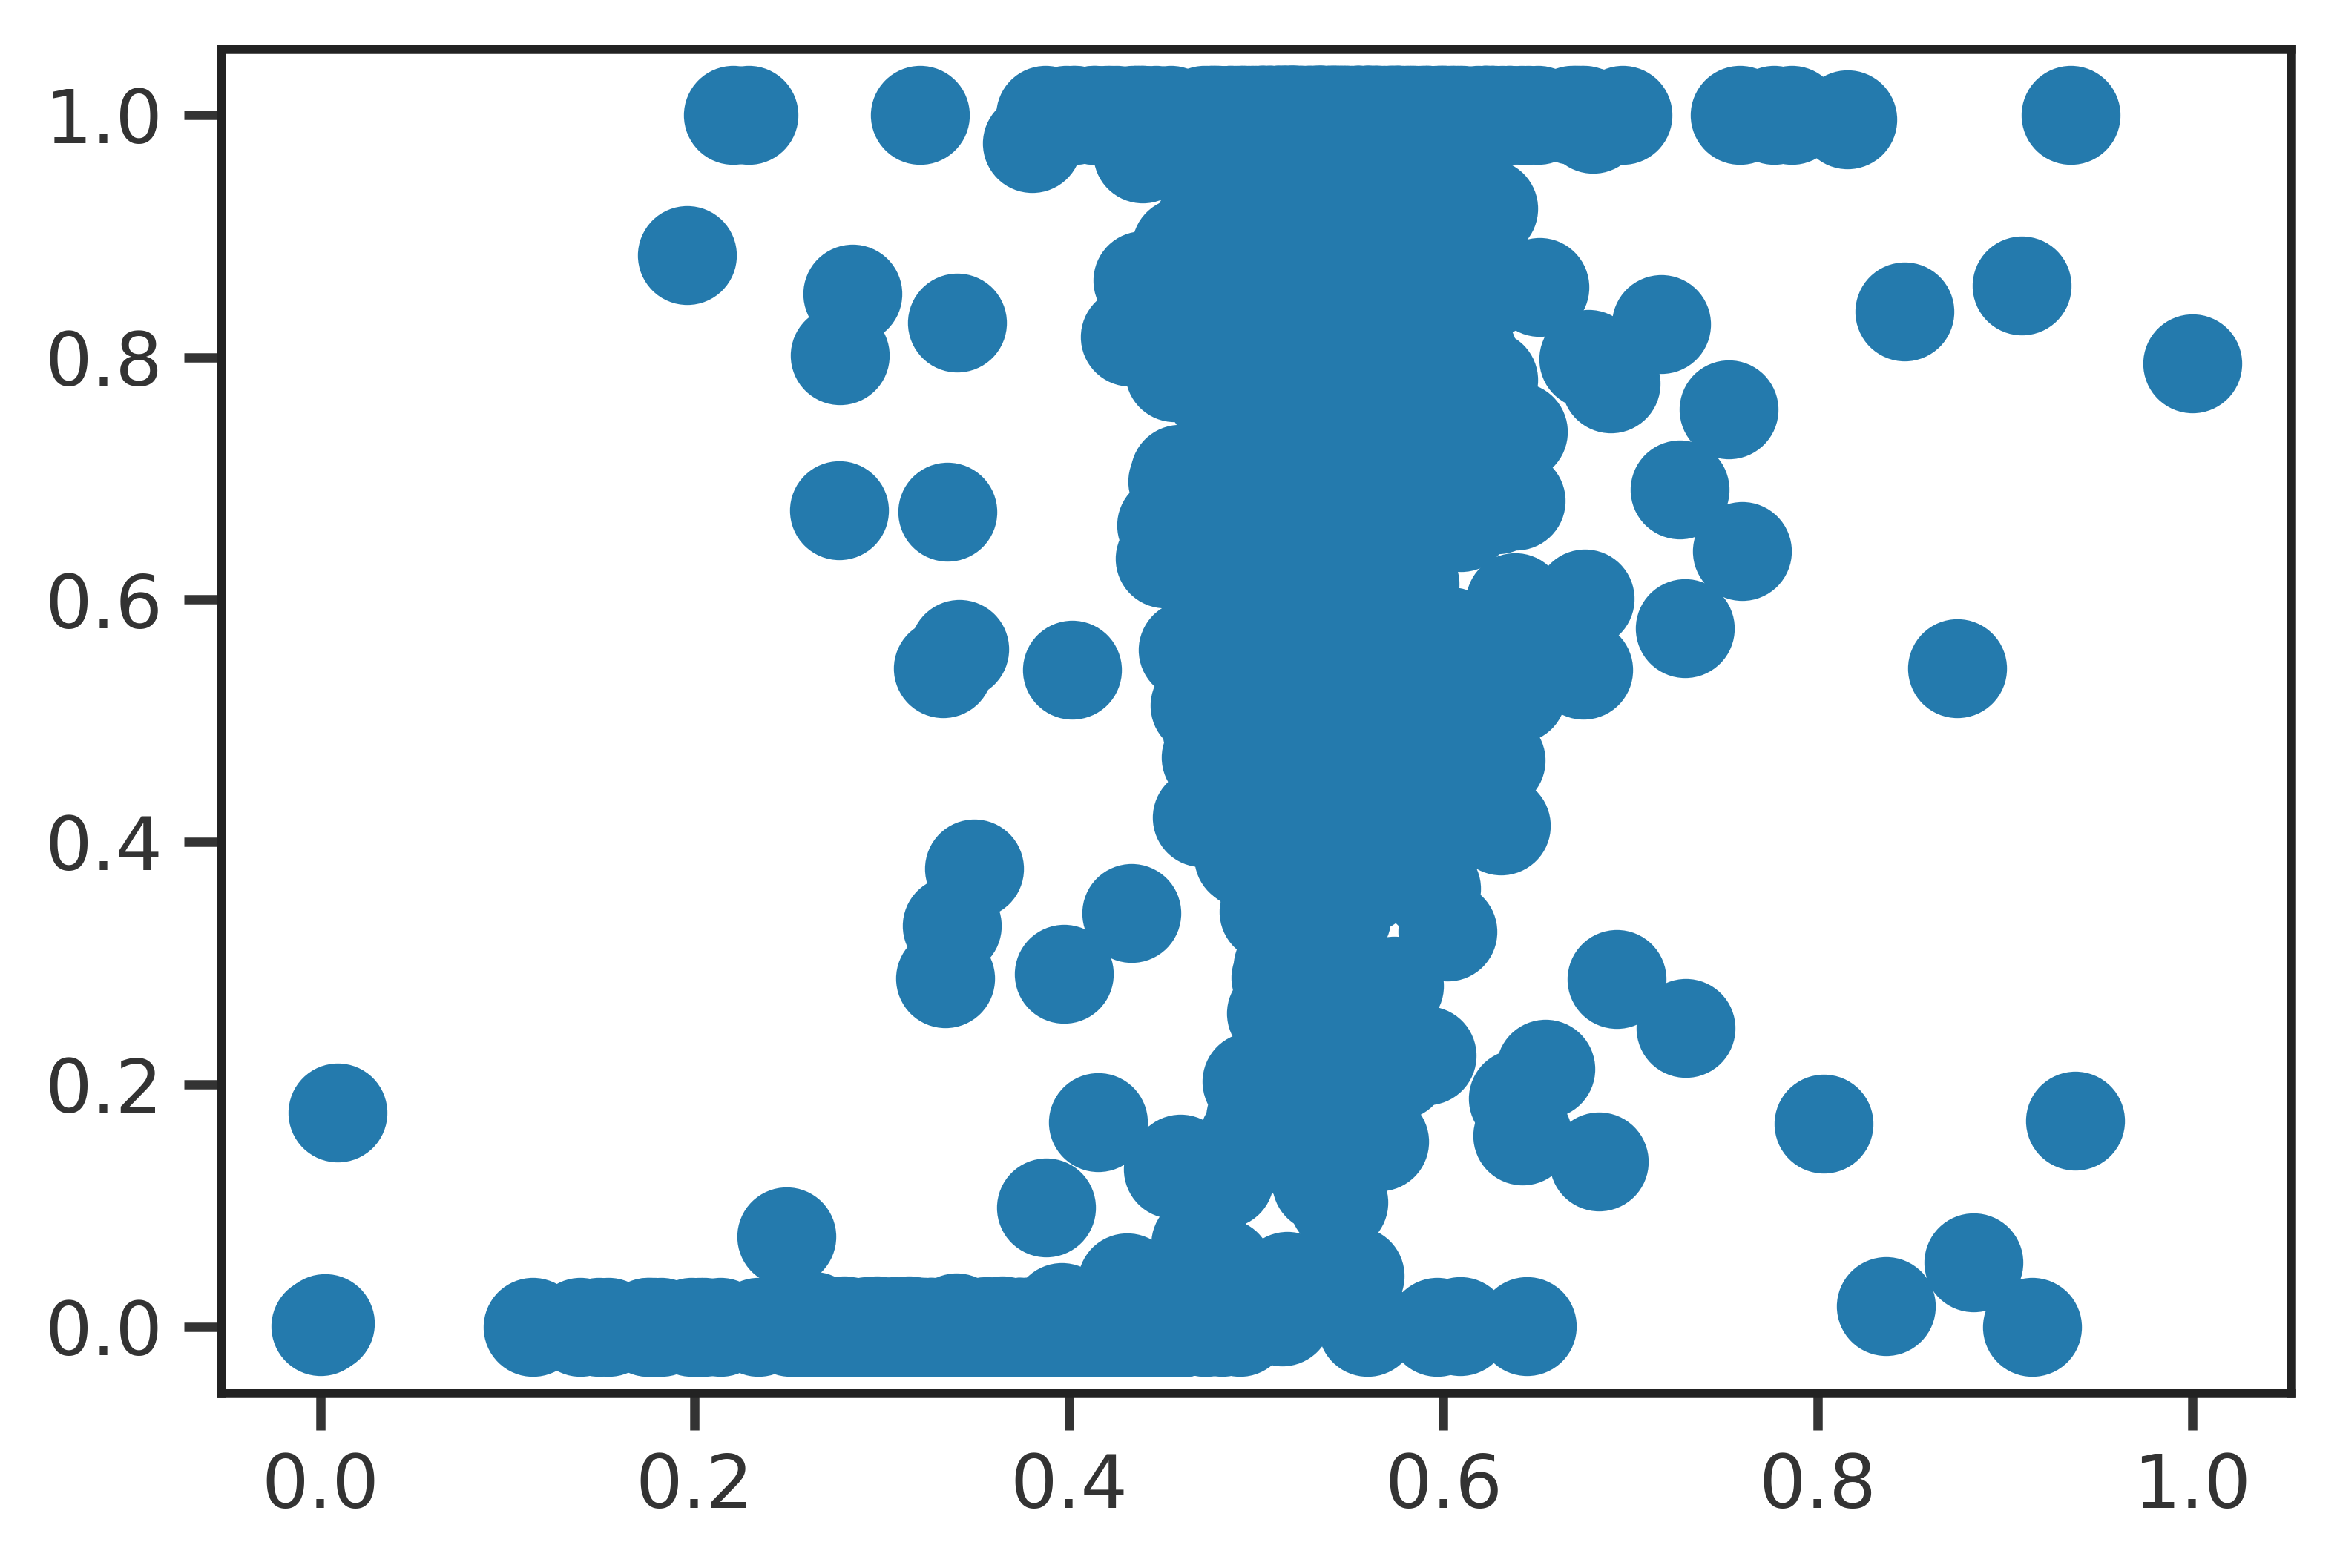

In [34]:
plt.scatter(np.stack(popts)[:,1], np.stack(popts)[:,0])

## Fig 4D with new spatial frequency fitting procedure

In [30]:
min_info = np.min(info_maps['medium_off_adapting'])
max_info = np.max(info_maps['medium_off_adapting'])

Ideal fit

In [36]:
total_sum = sum([sum(center_widths[celltype]) for celltype in center_widths.keys()])
mean_center_width = total_sum/sum([len(center_widths[celltype]) for celltype in center_widths.keys()])

In [38]:
rf = -np.fft.fftshift(np.fft.irfft(ideal_filter))
rf = np.append(rf, rf[-1])

center = gaussian(x=space, sigma=mean_center_width, mu=0.)
center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf

def rf_model(horz_weight, center_weight):
    horz_weight = np.min([1.0, abs(horz_weight)])
    center_weight = np.min([1.0, abs(center_weight)])
    return center_weight*center + (1-center_weight)*(horz_weight*horz_pf + (1-horz_weight)*ama_pf)

def model_error_to_ganglion_cells(weights):
    hw, cw = weights
    modeled_rf = rf_model(hw, cw)
    normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
    return sum(abs(normed_rf - rf))

best_fit_err = np.inf
for itr in range(iterations):
    this_popt = minimize(model_error_to_ganglion_cells, np.random.rand(2))
    if this_popt.fun < best_fit_err:
        best_fit_err = this_popt.fun
        popt = this_popt

# get mean squared error
modeled_rf = rf_model(*popt.x)
normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
mse = np.mean((normed_rf - rf)**2)

# truncate params between 0 and 1
#             x = np.where(popt.x < 0, 0, popt.x) # this actually is wrong, since I'm abs(params) in rf_model
#             x = np.where(x > 1, 1, x)
x = np.where(abs(popt.x) > 1, 1, abs(popt.x))
ideal_fit = x

Least info change direction

In [41]:
max_info_coordinates = collections.defaultdict(list)
least_info_directions = collections.defaultdict(list)
for celltype in info_maps.keys():
    for x in range(info_maps[celltype].shape[0]):
        for y in range(info_maps[celltype].shape[1]):
            # take cloud of high efficiency points
            if info_maps[celltype][x,y] >= 0.97*max_info:
                max_info_coordinates[celltype].append([horz_weights[x], center_weights[y]])
    pca = PCA()
    pca.fit(max_info_coordinates[celltype])
    print('PC1 has explained variance %0.2f%% percent for %s' %(pca.explained_variance_ratio_[0]*100, celltype))
    least_info_directions[celltype] = abs(pca.components_[-1])
    
average_least_info_direction = np.mean([least_info_directions[k] for k in least_info_directions.keys()], axis=0)

PC1 has explained variance 99.68% percent for medium_off_adapting
PC1 has explained variance 99.76% percent for fast_off_adapting
PC1 has explained variance 99.91% percent for fast_on
PC1 has explained variance 99.52% percent for ganglion
PC1 has explained variance 99.67% percent for slow_off
PC1 has explained variance 99.94% percent for fast_off_sensitizing


Direction of variance in fits

In [44]:
all_fits = []
for celltype in fits_fft.keys():
    all_fits.extend(fits_fft[celltype])
    
pca = PCA(n_components=2)
pca.fit(all_fits)

# flipping the dimensions because fits was saved as horz_weight, center_weight
average_variance_direction = abs(np.array([pca.components_[0][1], pca.components_[0][0]]))
print('PC1 has explained variance %0.2f%% percent for all cells' %(pca.explained_variance_ratio_[0]*100))

PC1 has explained variance 90.18% percent for all cells


/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


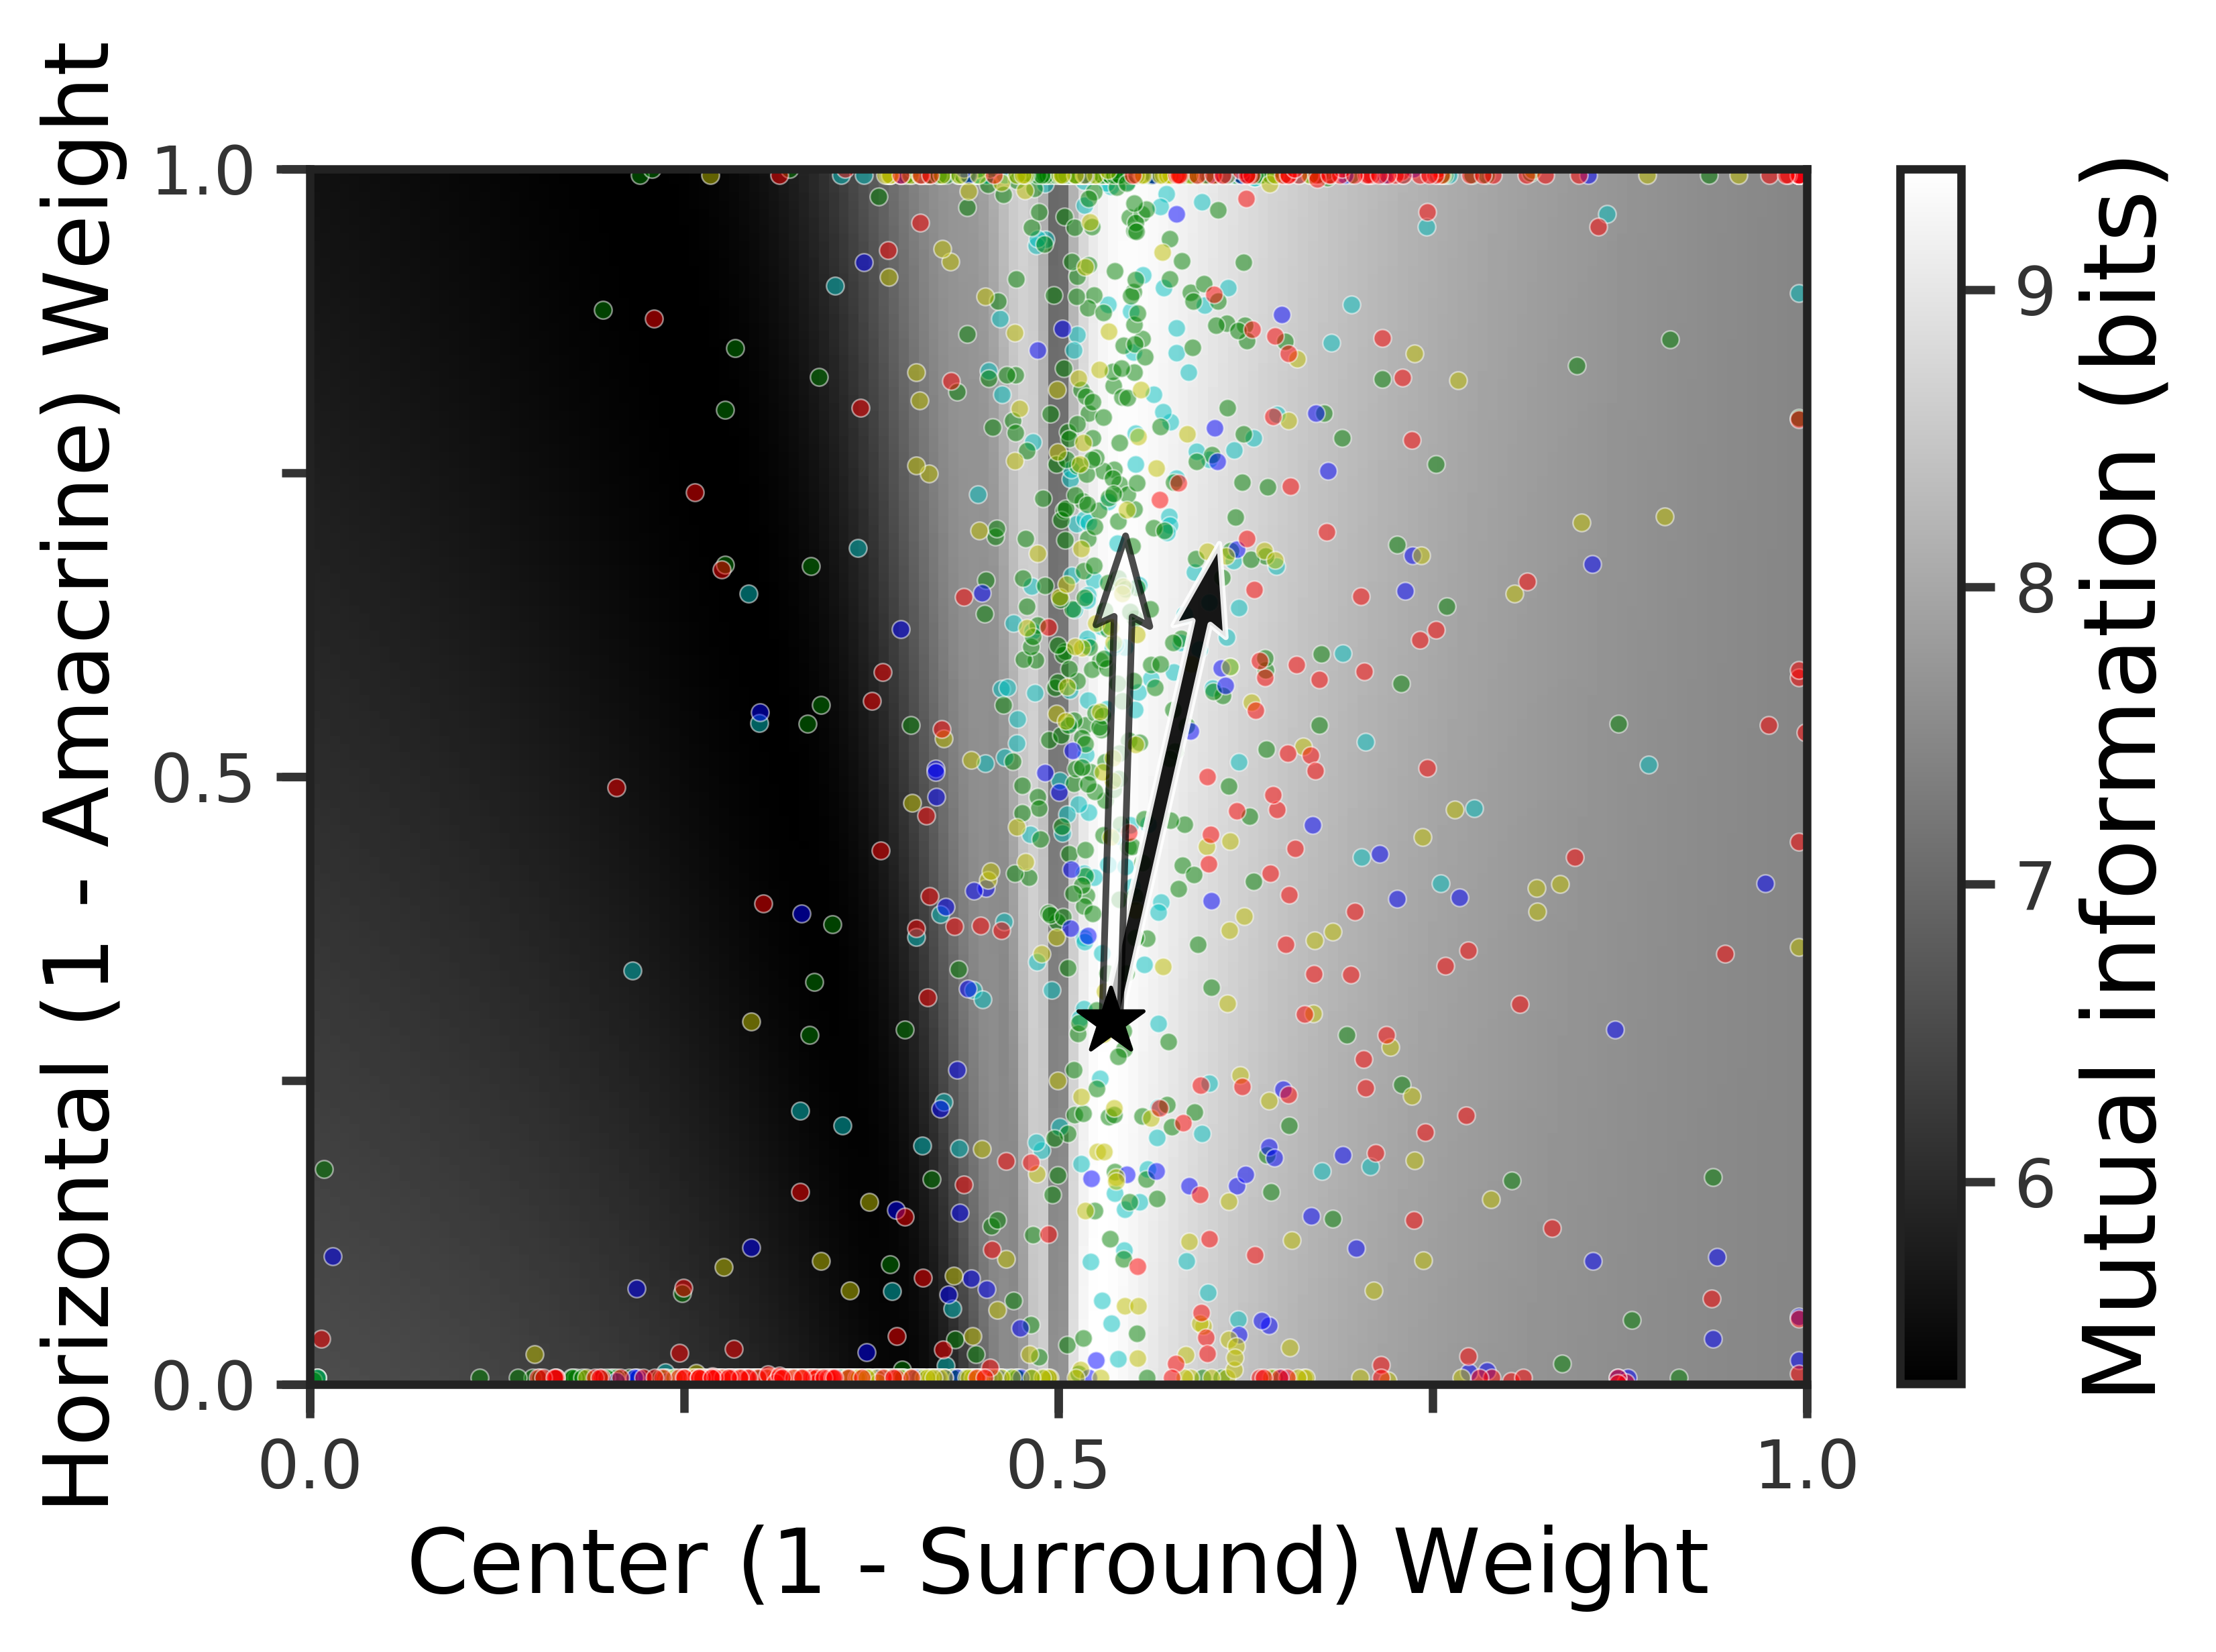

In [46]:
plt.imshow(info_maps['medium_off_adapting'], extent=(center_weights[0], center_weights[-1], horz_weights[-1], horz_weights[0]),
              aspect='auto', clim=[min_info, max_info])
cbar = plt.colorbar()
cbar.set_ticks([6,7,8,9])
# plt.clim(0,np.max(info_color_map))
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)

for idc, celltype in enumerate([k for k in info_maps.keys() if k != 'ganglion']):
    # make the points lying on the edges more visible
    adjusted_fits1 = np.where(fits_fft[celltype] == 1, 0.995, fits_fft[celltype])
    adjusted_fits = np.where(adjusted_fits1 < 0.001, 0.005, adjusted_fits1)
    plt.scatter(adjusted_fits[:,1], adjusted_fits[:,0],
                c=colorscheme[celltype], edgecolor='w', s=10, alpha=0.5, label=' '.join(celltype.split('_')),
                linewidth=0.3)
#     plt.scatter(adjusted_fits[example_ids[celltype]][:nexamples_for_this_plot,1],
#                adjusted_fits[example_ids[celltype]][:nexamples_for_this_plot,0],
#                c=colorscheme[celltype], edgecolor='k', s=60, marker='*', linewidth=0.7)


plt.quiver(ideal_fit[1], ideal_fit[0], average_variance_direction[0], average_variance_direction[1],
           angles='xy', scale_units='xy', scale=2.5, color='k', edgecolor='w', width=0.012, linewidth=1,
          alpha=0.9)
plt.quiver(ideal_fit[1], ideal_fit[0], average_least_info_direction[0], average_least_info_direction[1],
           angles='xy', scale_units='xy', scale=2.5, color='w', edgecolor='k',
          alpha=0.7, width=.012, linewidth=1.2)
plt.scatter(ideal_fit[1], ideal_fit[0], c='k', edgecolor='k', s=150, marker='*', linewidth=0.7)

# l = plt.legend(loc='upper left', frameon=False, fontsize=8)
# for text in l.get_texts():
#     text.set_color("white")
plt.ylim([0,1])
plt.xlim([center_weights[0], center_weights[-1]])


# specify ticks
# plt.xticks([0, 0.25, 0.5, 0.75, 1])
# plt.yticks([0, 0.25, 0.5, 0.75, 1])
majorLocator = MultipleLocator(0.5)
majorFormatter = FormatStrFormatter('%0.1f')
minorLocator = MultipleLocator(0.25)

ax = plt.gca()
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.xaxis.set_minor_locator(minorLocator)
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)

# plt.title('Total information of various models \n with fitted ganglion cells', fontsize=16)
plt.xlabel('Center (1 - Surround) Weight', fontsize=16)
plt.ylabel('Horizontal (1 - Amacrine) Weight', fontsize=16)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
# plt.savefig('Figures for Steve IV.png')

/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


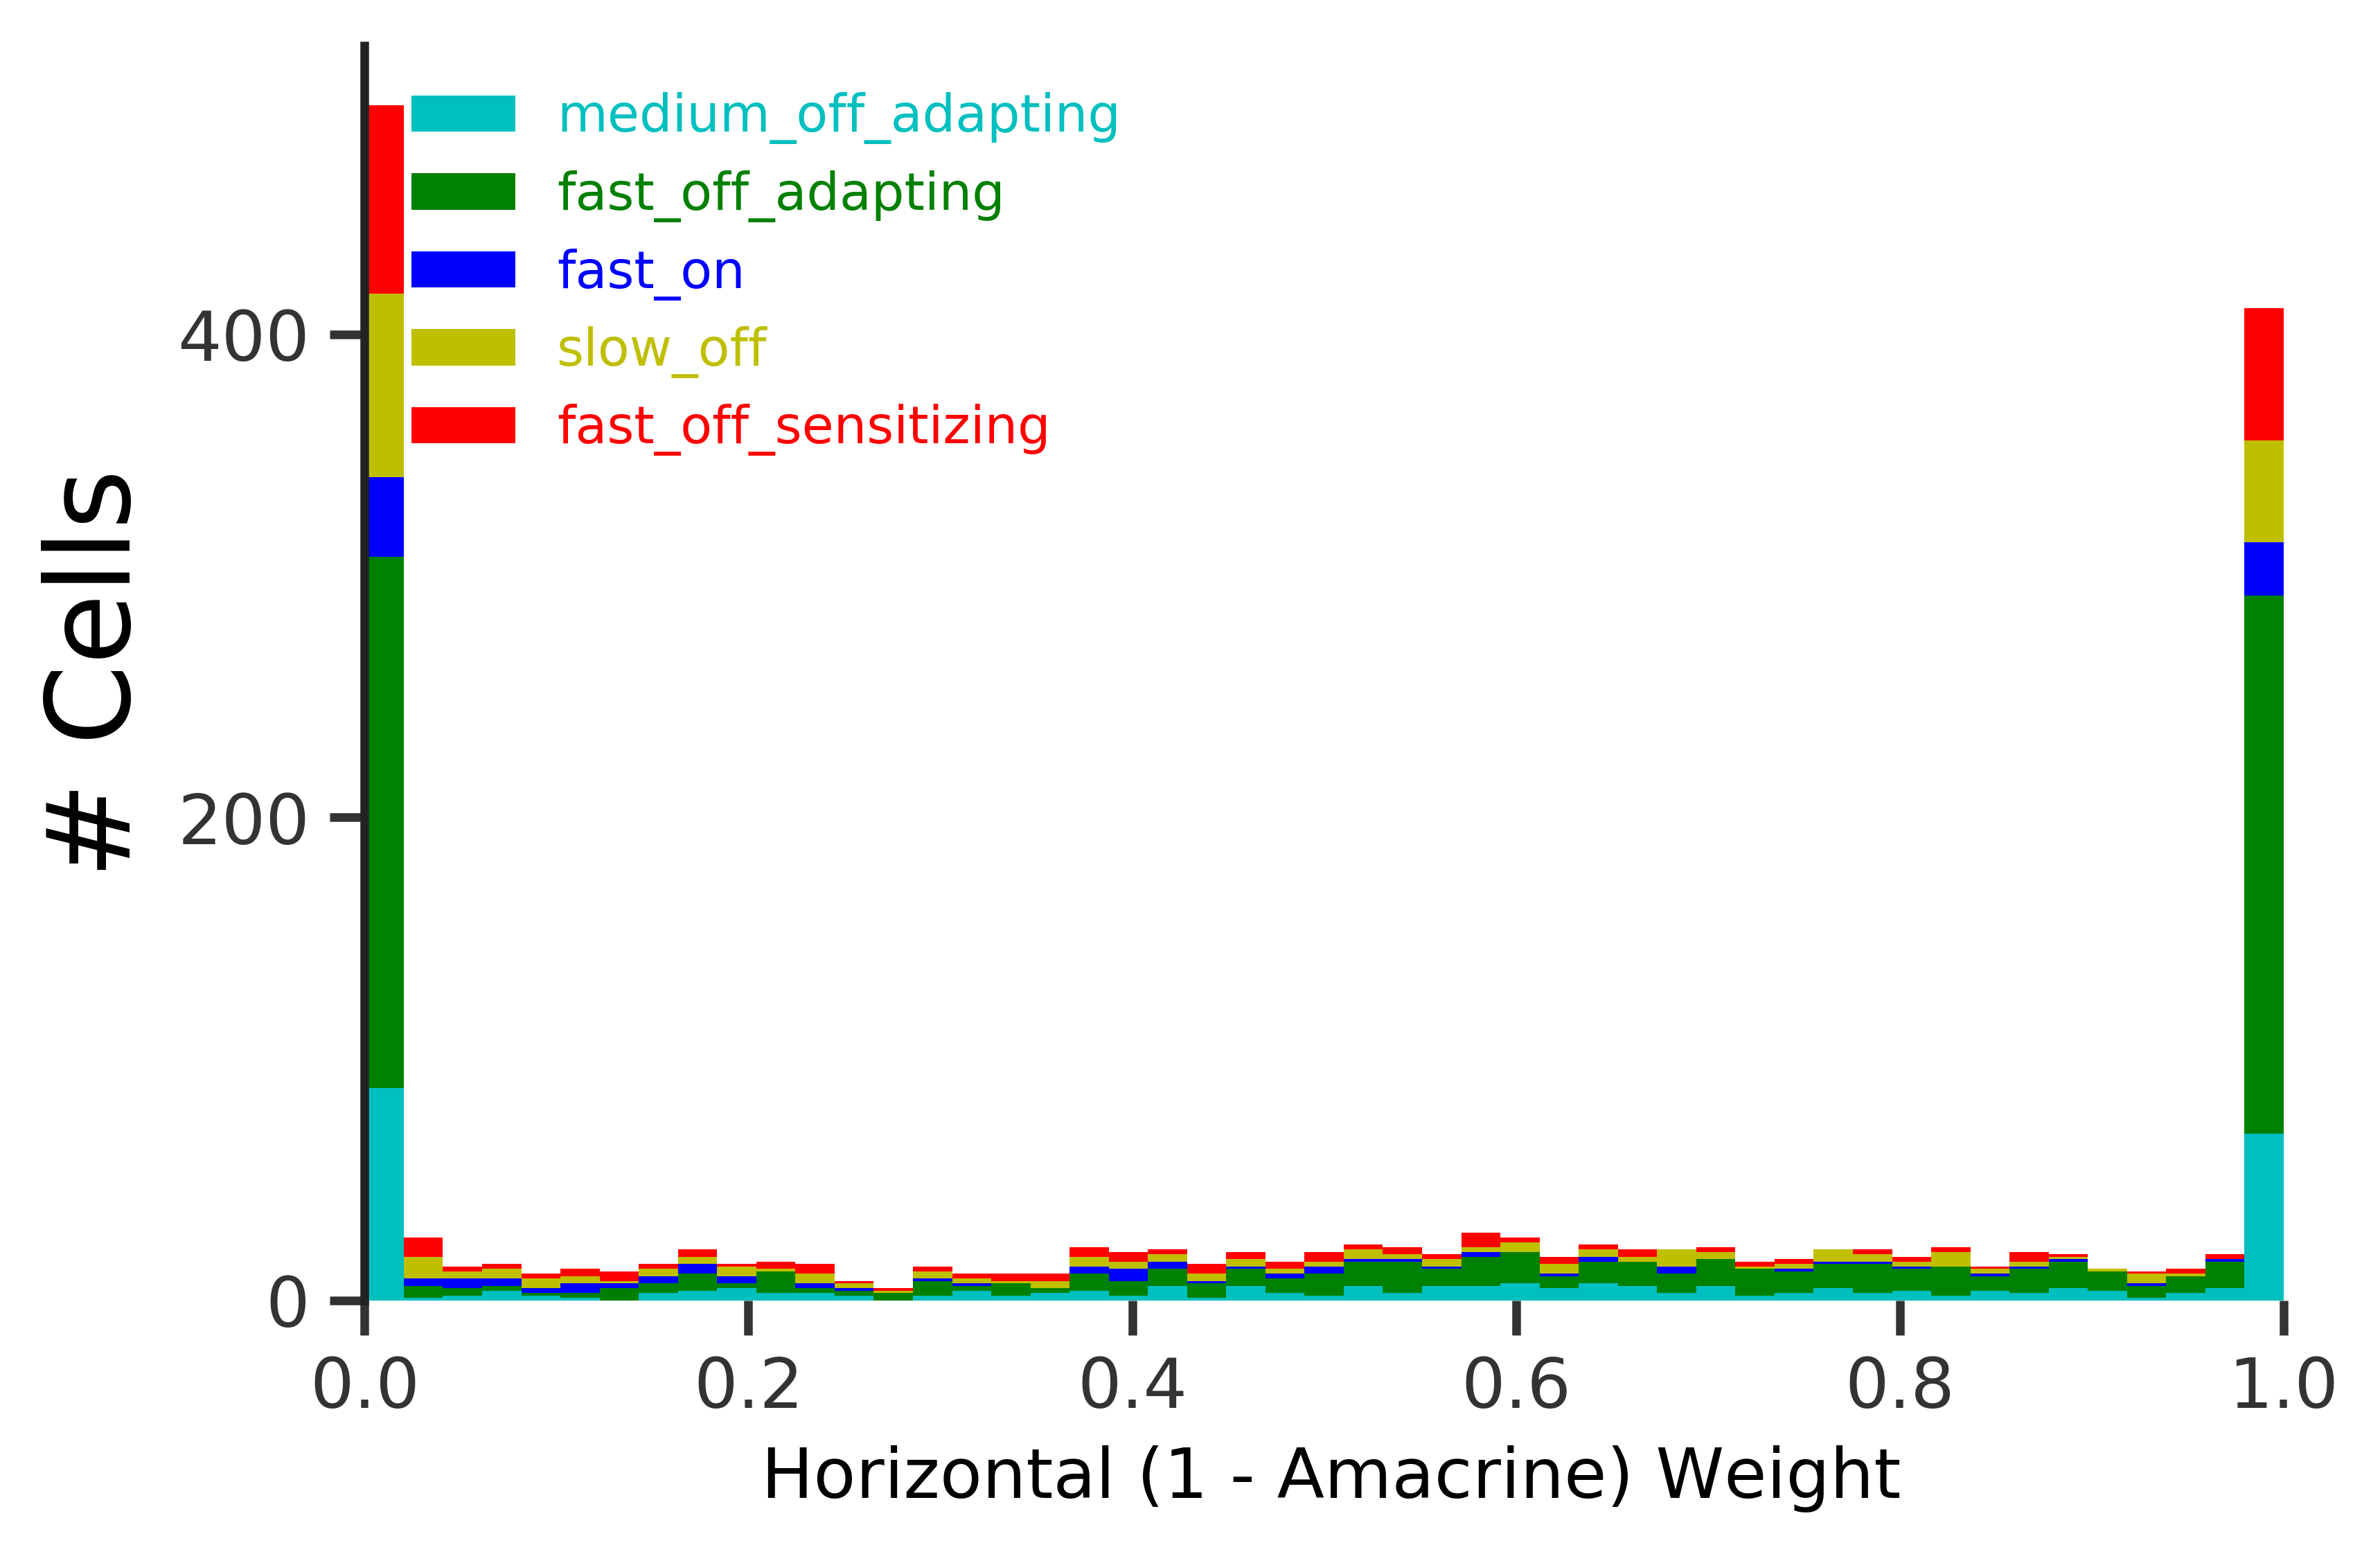

In [48]:
fig = plt.gcf()
ax = plt.gca()

# Histogram
bin_edges = np.linspace(0, 1, 50)
bin_width = np.mean(np.diff(bin_edges))
prev_count = np.zeros_like(bin_edges[:-1])
for c, celltype in enumerate(fits_fft.keys()):
    if celltype != 'ganglion':
        this_count, bins = np.histogram(np.stack(fits_fft[celltype])[:, 0], bins=bin_edges)
        ax.bar(bin_edges[:-1] + bin_width/2, this_count, color=colorscheme[celltype], width=bin_width,
               bottom=prev_count, linewidth=0.5, label=' '.join(celltype.split(' ')))
        prev_count += this_count
        
l = plt.legend(frameon=False, fontsize=9, loc='upper left')
for text in l.get_texts():
    splitlabel = text.properties()['text'].split(' ')
    text.set_color(colorscheme['_'.join(splitlabel)])

        

plt.xlim(0,1.007)
# plt.xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_ylabel('# Cells', color='k', fontsize=20)
ax.set_xlabel('Horizontal (1 - Amacrine) Weight')
# ax.set_ylim(0,300)
# ax.set_yticks([0,100,200,300])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['bottom'].set_visible(False)

# ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')



majorLocator = MultipleLocator(200)
majorFormatter = FormatStrFormatter('%d')

ax = plt.gca()
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
# ax.xaxis.set_minor_locator(minorLocator)

# ax.yaxis.set_ticks_position('left')
# adjust_spines(plt.gca())
# plt.xlabel('Center (1 - surround) weight')
# plt.ylabel('# Cells')
# plt.savefig('1d y-axis distribution 3-2.png')

In [ ]:
# fits_fft = collections.defaultdict(list)
# mean_squared_errors_fft = collections.defaultdict(list)
# abs_errors_fft = collections.defaultdict(list)
# variances_fft = collections.defaultdict(list)
# fft_centers

/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


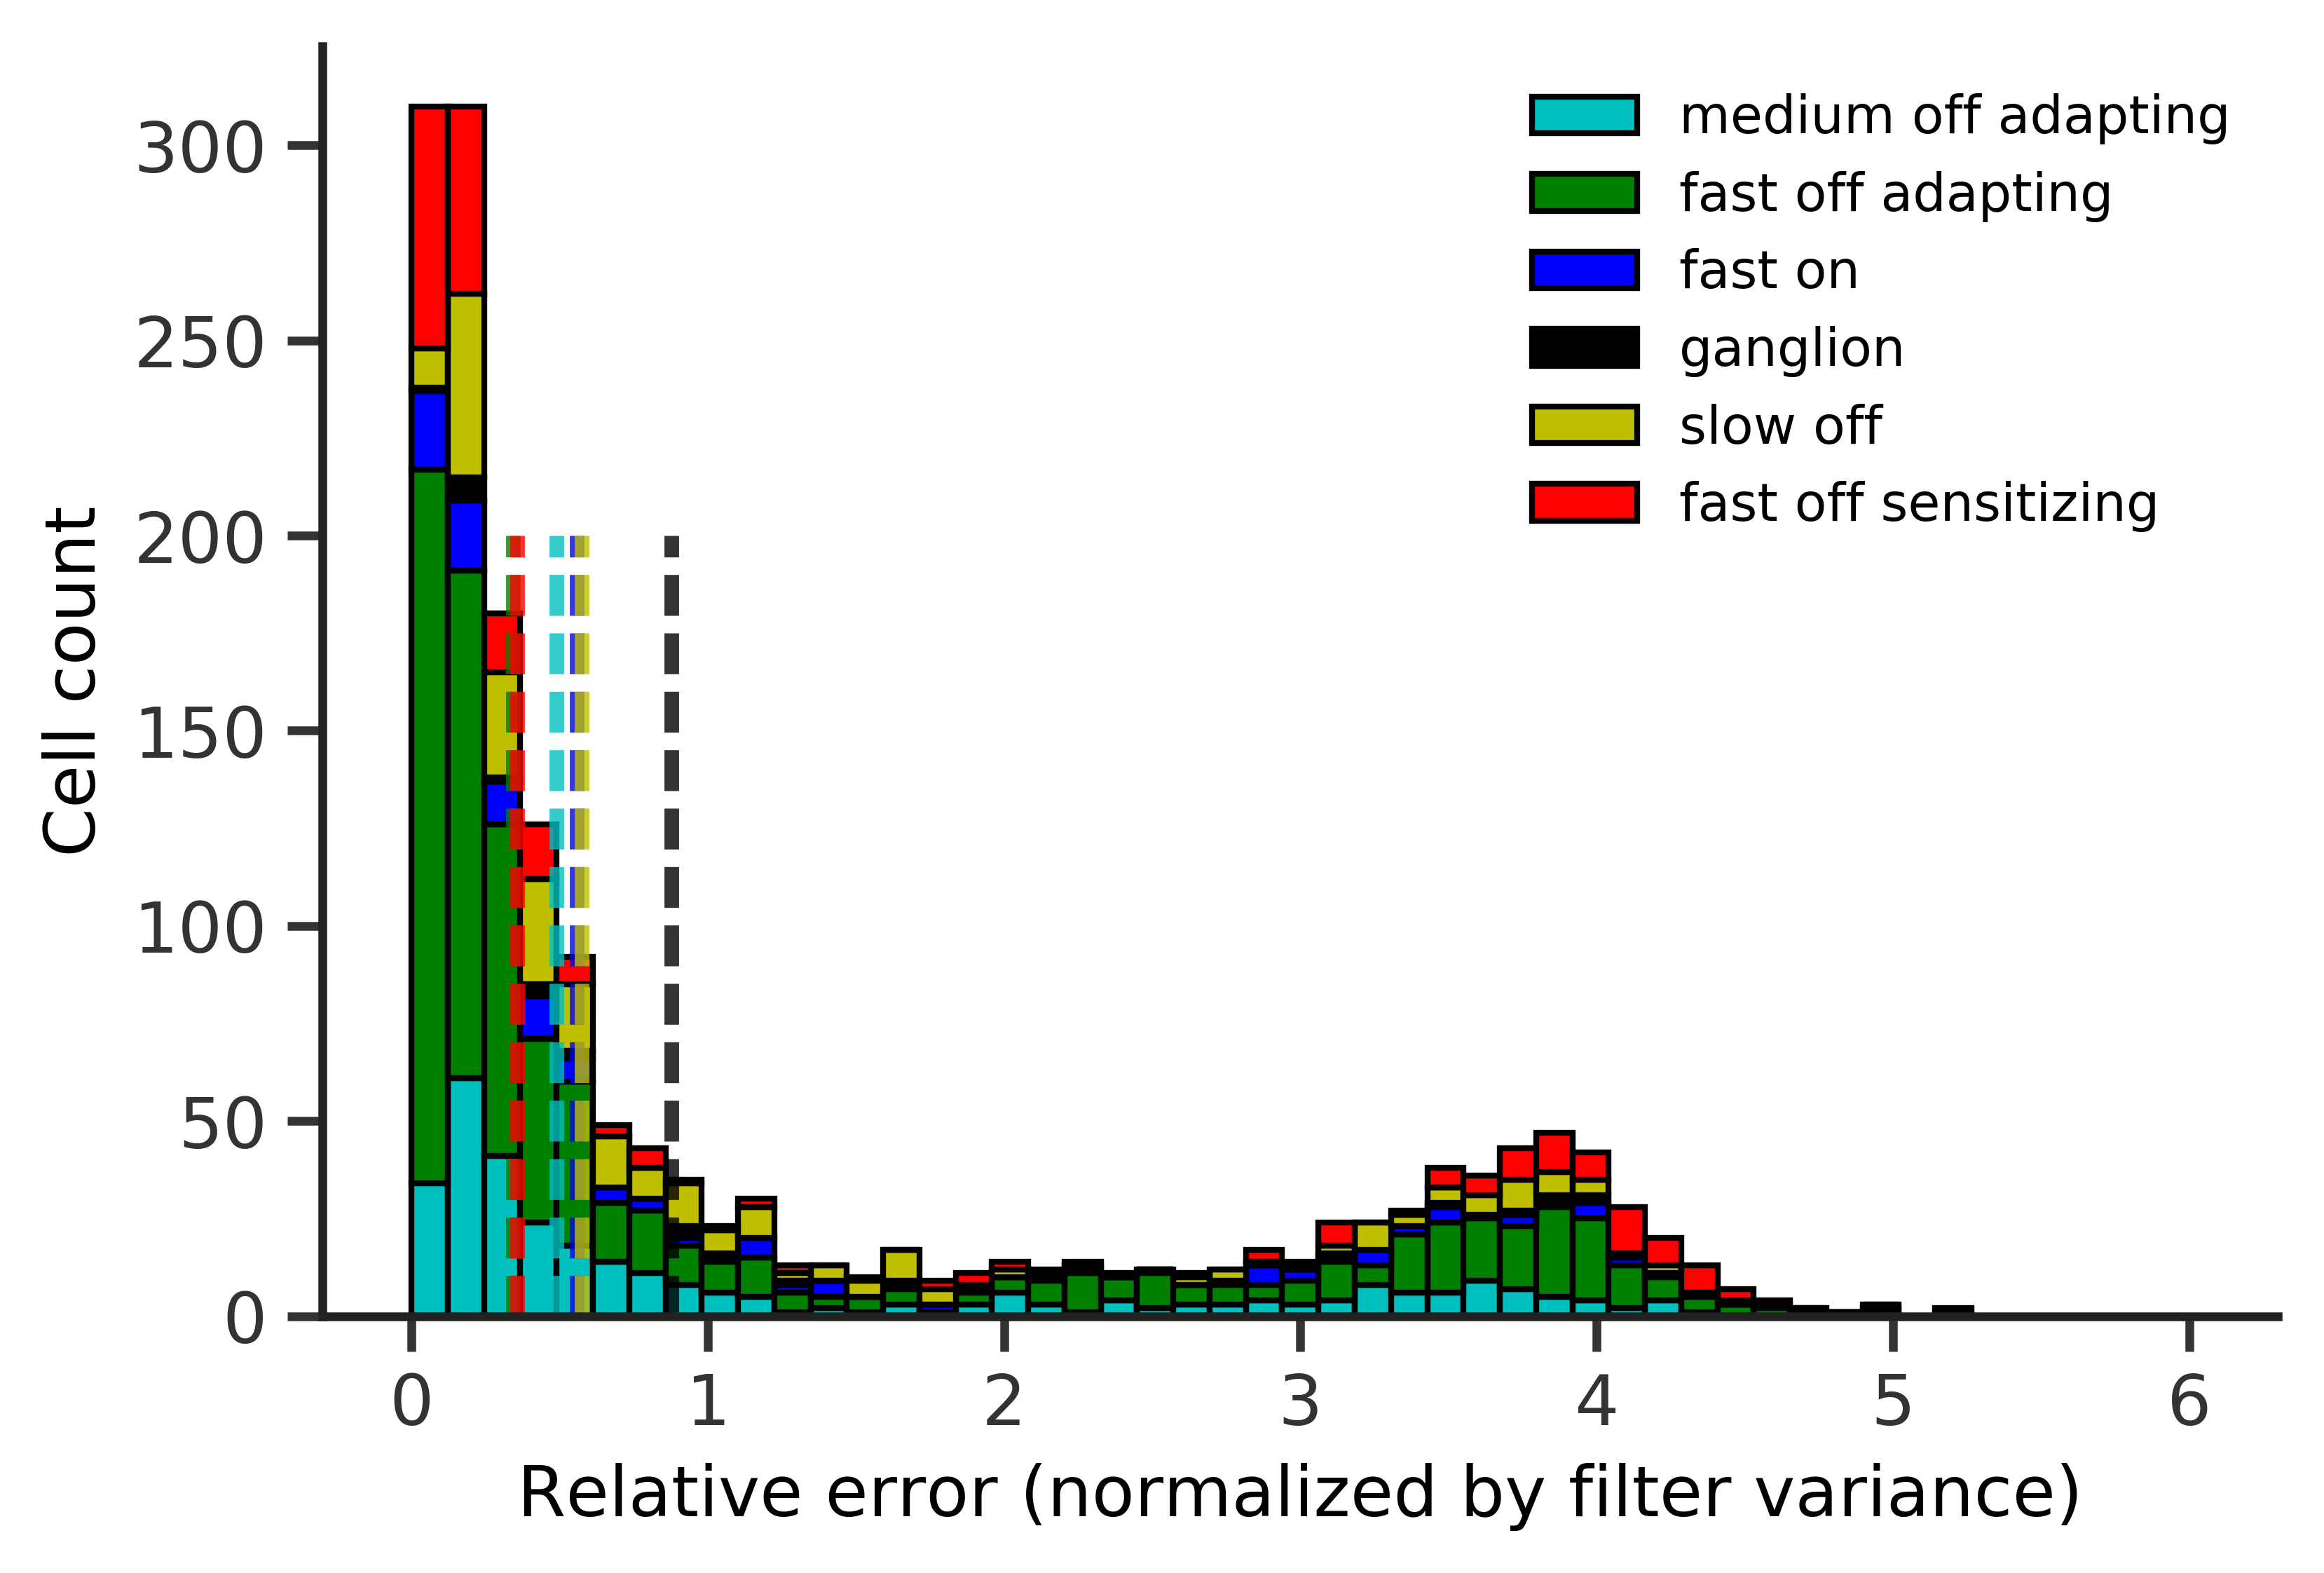

In [53]:
bins = np.linspace(0,6,50)
bin_width = np.mean(np.diff(bins))
prev_count = np.zeros_like(bins[:-1])
for celltype in mean_squared_errors_fft.keys():
    rel_error = np.array(mean_squared_errors_fft[celltype])/np.array(variances_fft[celltype])
    count, bins = np.histogram(rel_error, bins=bins)

    plt.bar(bins[:-1]+bin_width/2, count, width=bin_width, color=colorscheme[celltype], 
            label=' '.join(celltype.split('_')), edgecolor='k', bottom=prev_count)
    prev_count += count
    
    plt.vlines(np.median(rel_error), 0, 200, color=colorscheme[celltype], linestyle='--', alpha=0.8)

plt.legend(loc='upper right', frameon=False, fontsize=9)
plt.xlabel('Relative error (normalized by filter variance)')
plt.ylabel('Cell count')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
# plt.ylim(0,200)
# plt.savefig('Percent variance explained by model with median.png')

### Look at individual examples

Some examples of Horizontal-only fits

/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


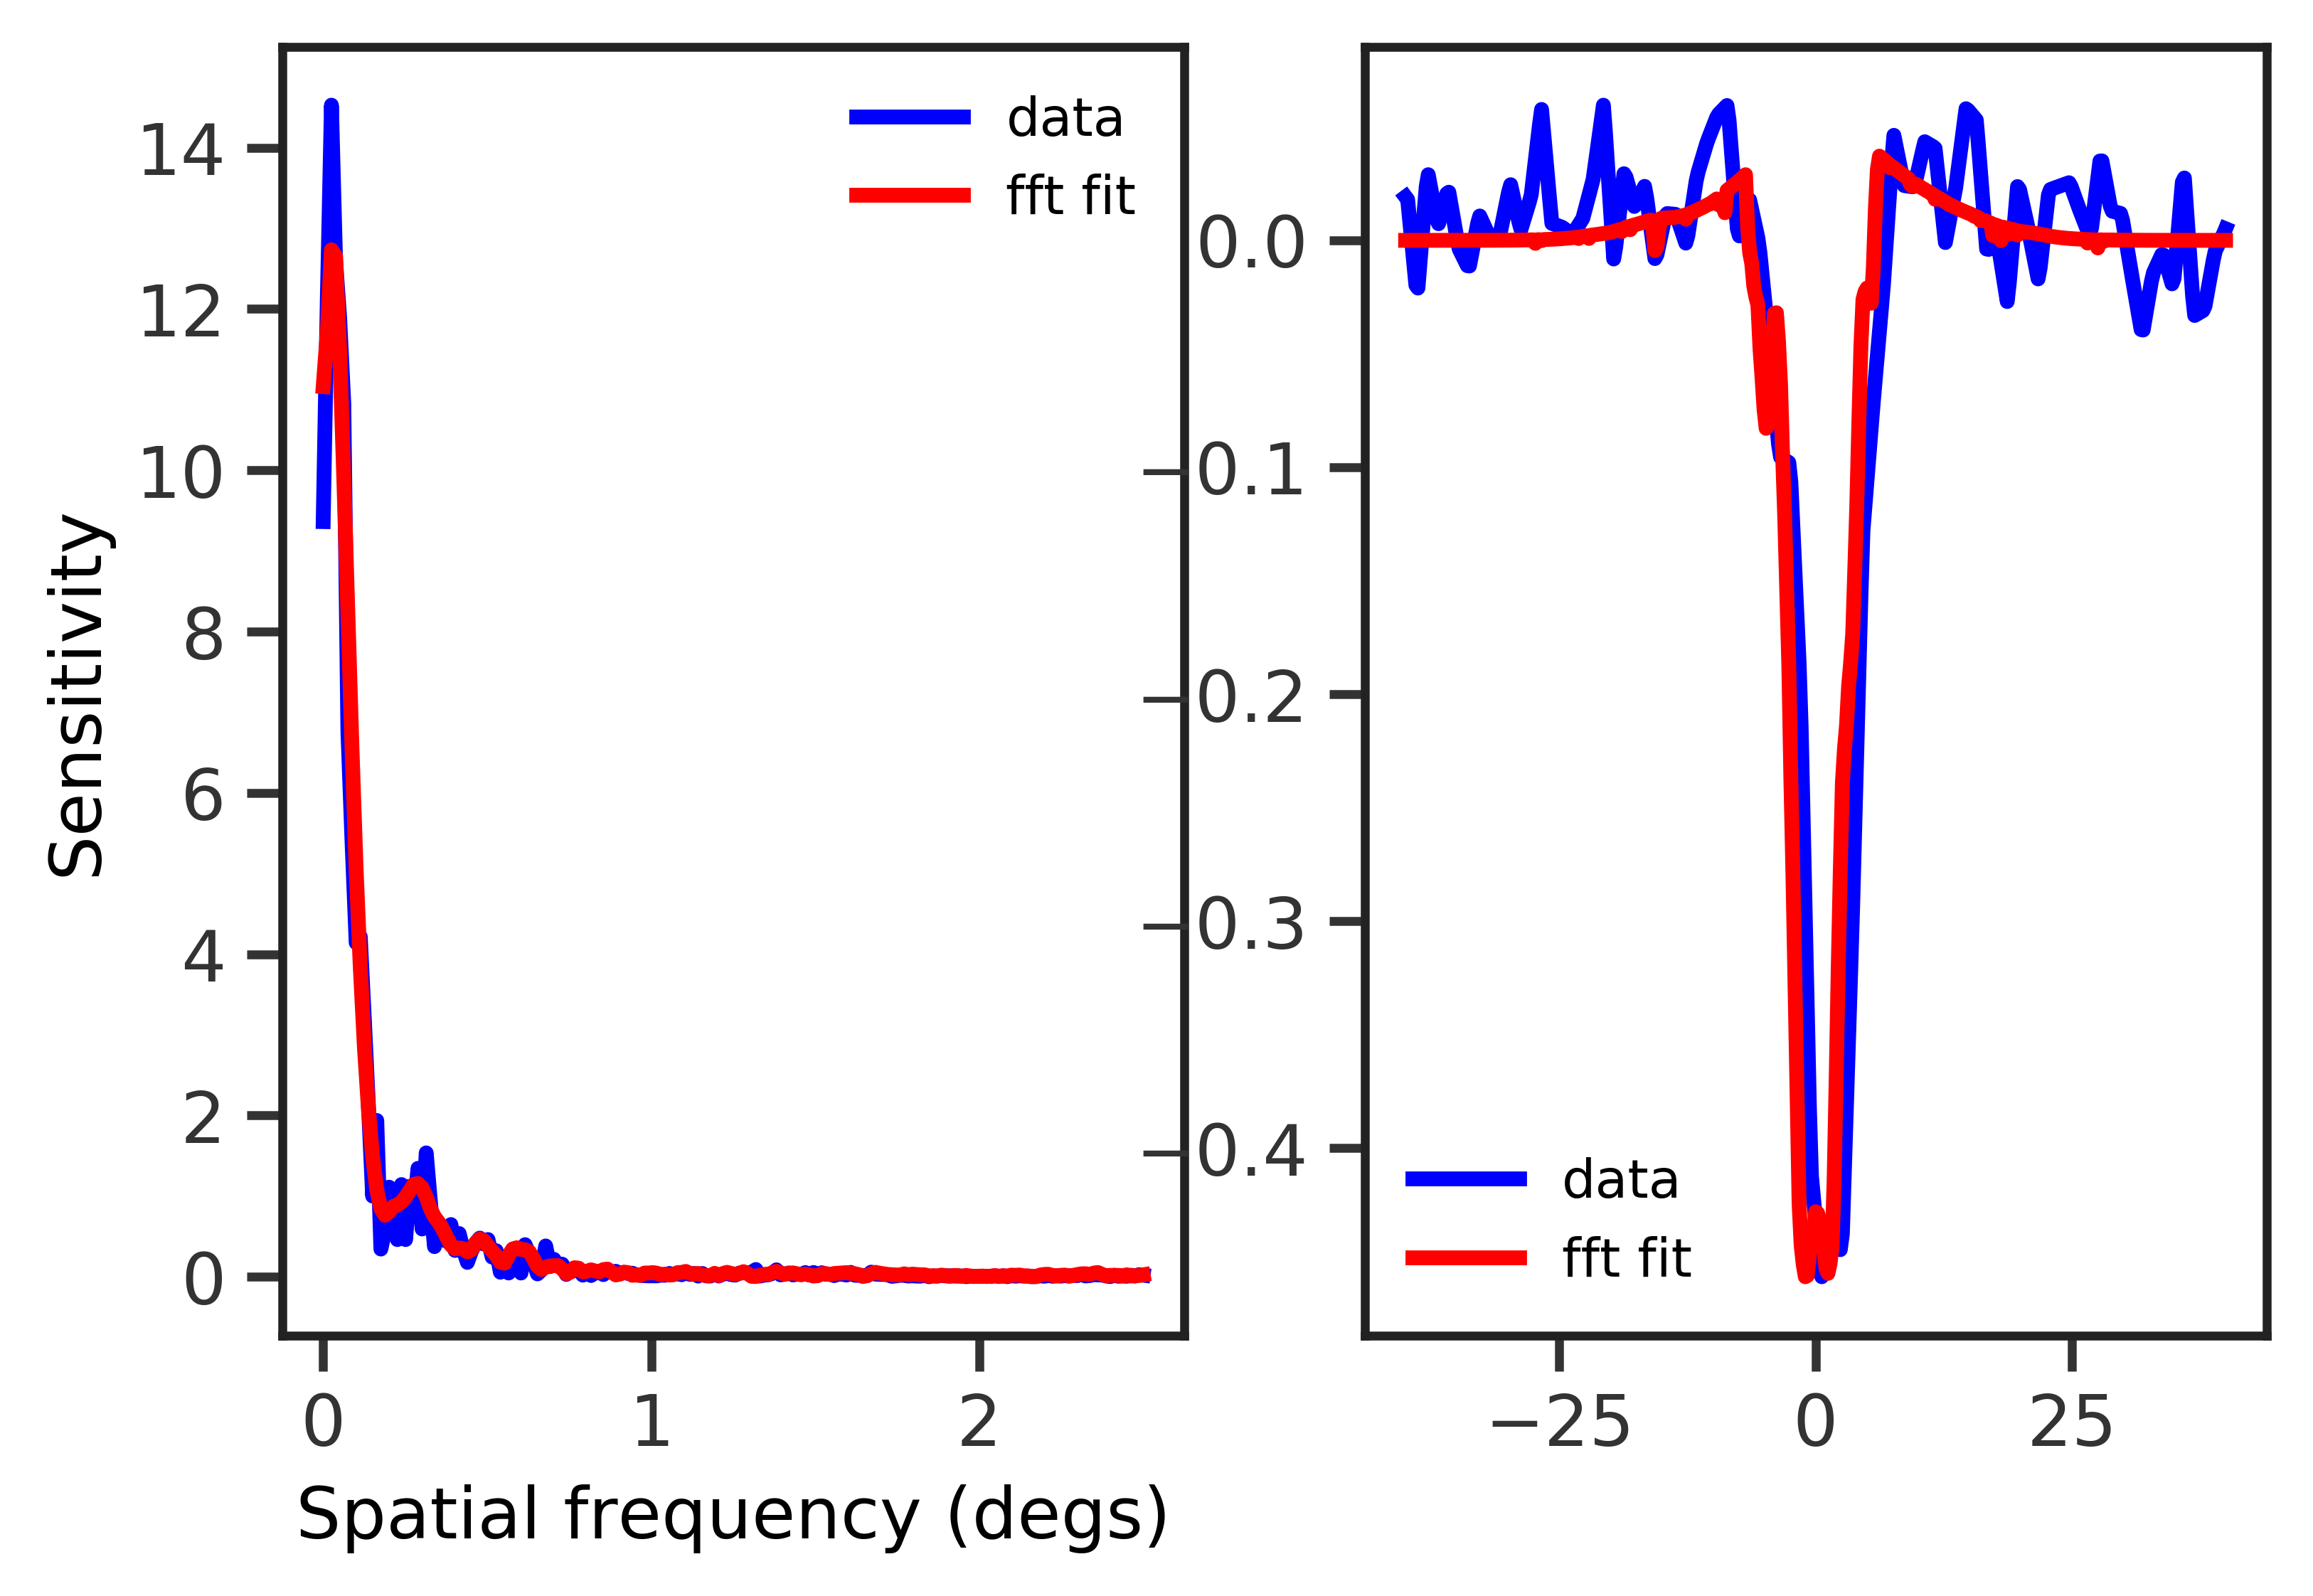

In [59]:
def rf_model(center, horz_weight, center_weight):
    # do the same transformation that happens in model_error_to_ganglion_cells
    center = np.where(center < 0, center, 0)
    center /= abs(np.sum(center))

    horz_weight = np.min([1.0, abs(horz_weight)])
    center_weight = np.min([1.0, abs(center_weight)])
    return center_weight*center + (1-center_weight)*(horz_weight*horz_pf + (1-horz_weight)*ama_pf)

celltype = 'medium_off_adapting'
count = 0
for idf, (hw, cw) in enumerate(fits_fft[celltype]):
    if (hw == 1.0) and (count < 1):
        
        rf = receptive_fields[celltype][idf]
        modeled_rf = rf_model(fft_centers[celltype][idf], hw, cw)
        normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
        
        y = abs(np.fft.rfft(rf))
        y_hat = abs(np.fft.rfft(normed_rf))
        
        plt.subplot(121)
        plt.plot(freqs, y, 'b', label='data')
        plt.plot(freqs, y_hat, 'r', label='fft fit')
        plt.ylabel('Sensitivity')
        plt.xlabel('Spatial frequency (degs)')
        plt.legend(frameon=False, fontsize=9)
        
        plt.subplot(122)
        plt.plot(space, rf, 'b', label='data')
        plt.plot(space, normed_rf, 'r', label='fft fit')
        plt.legend(frameon=False, fontsize=9)
        count += 1

/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


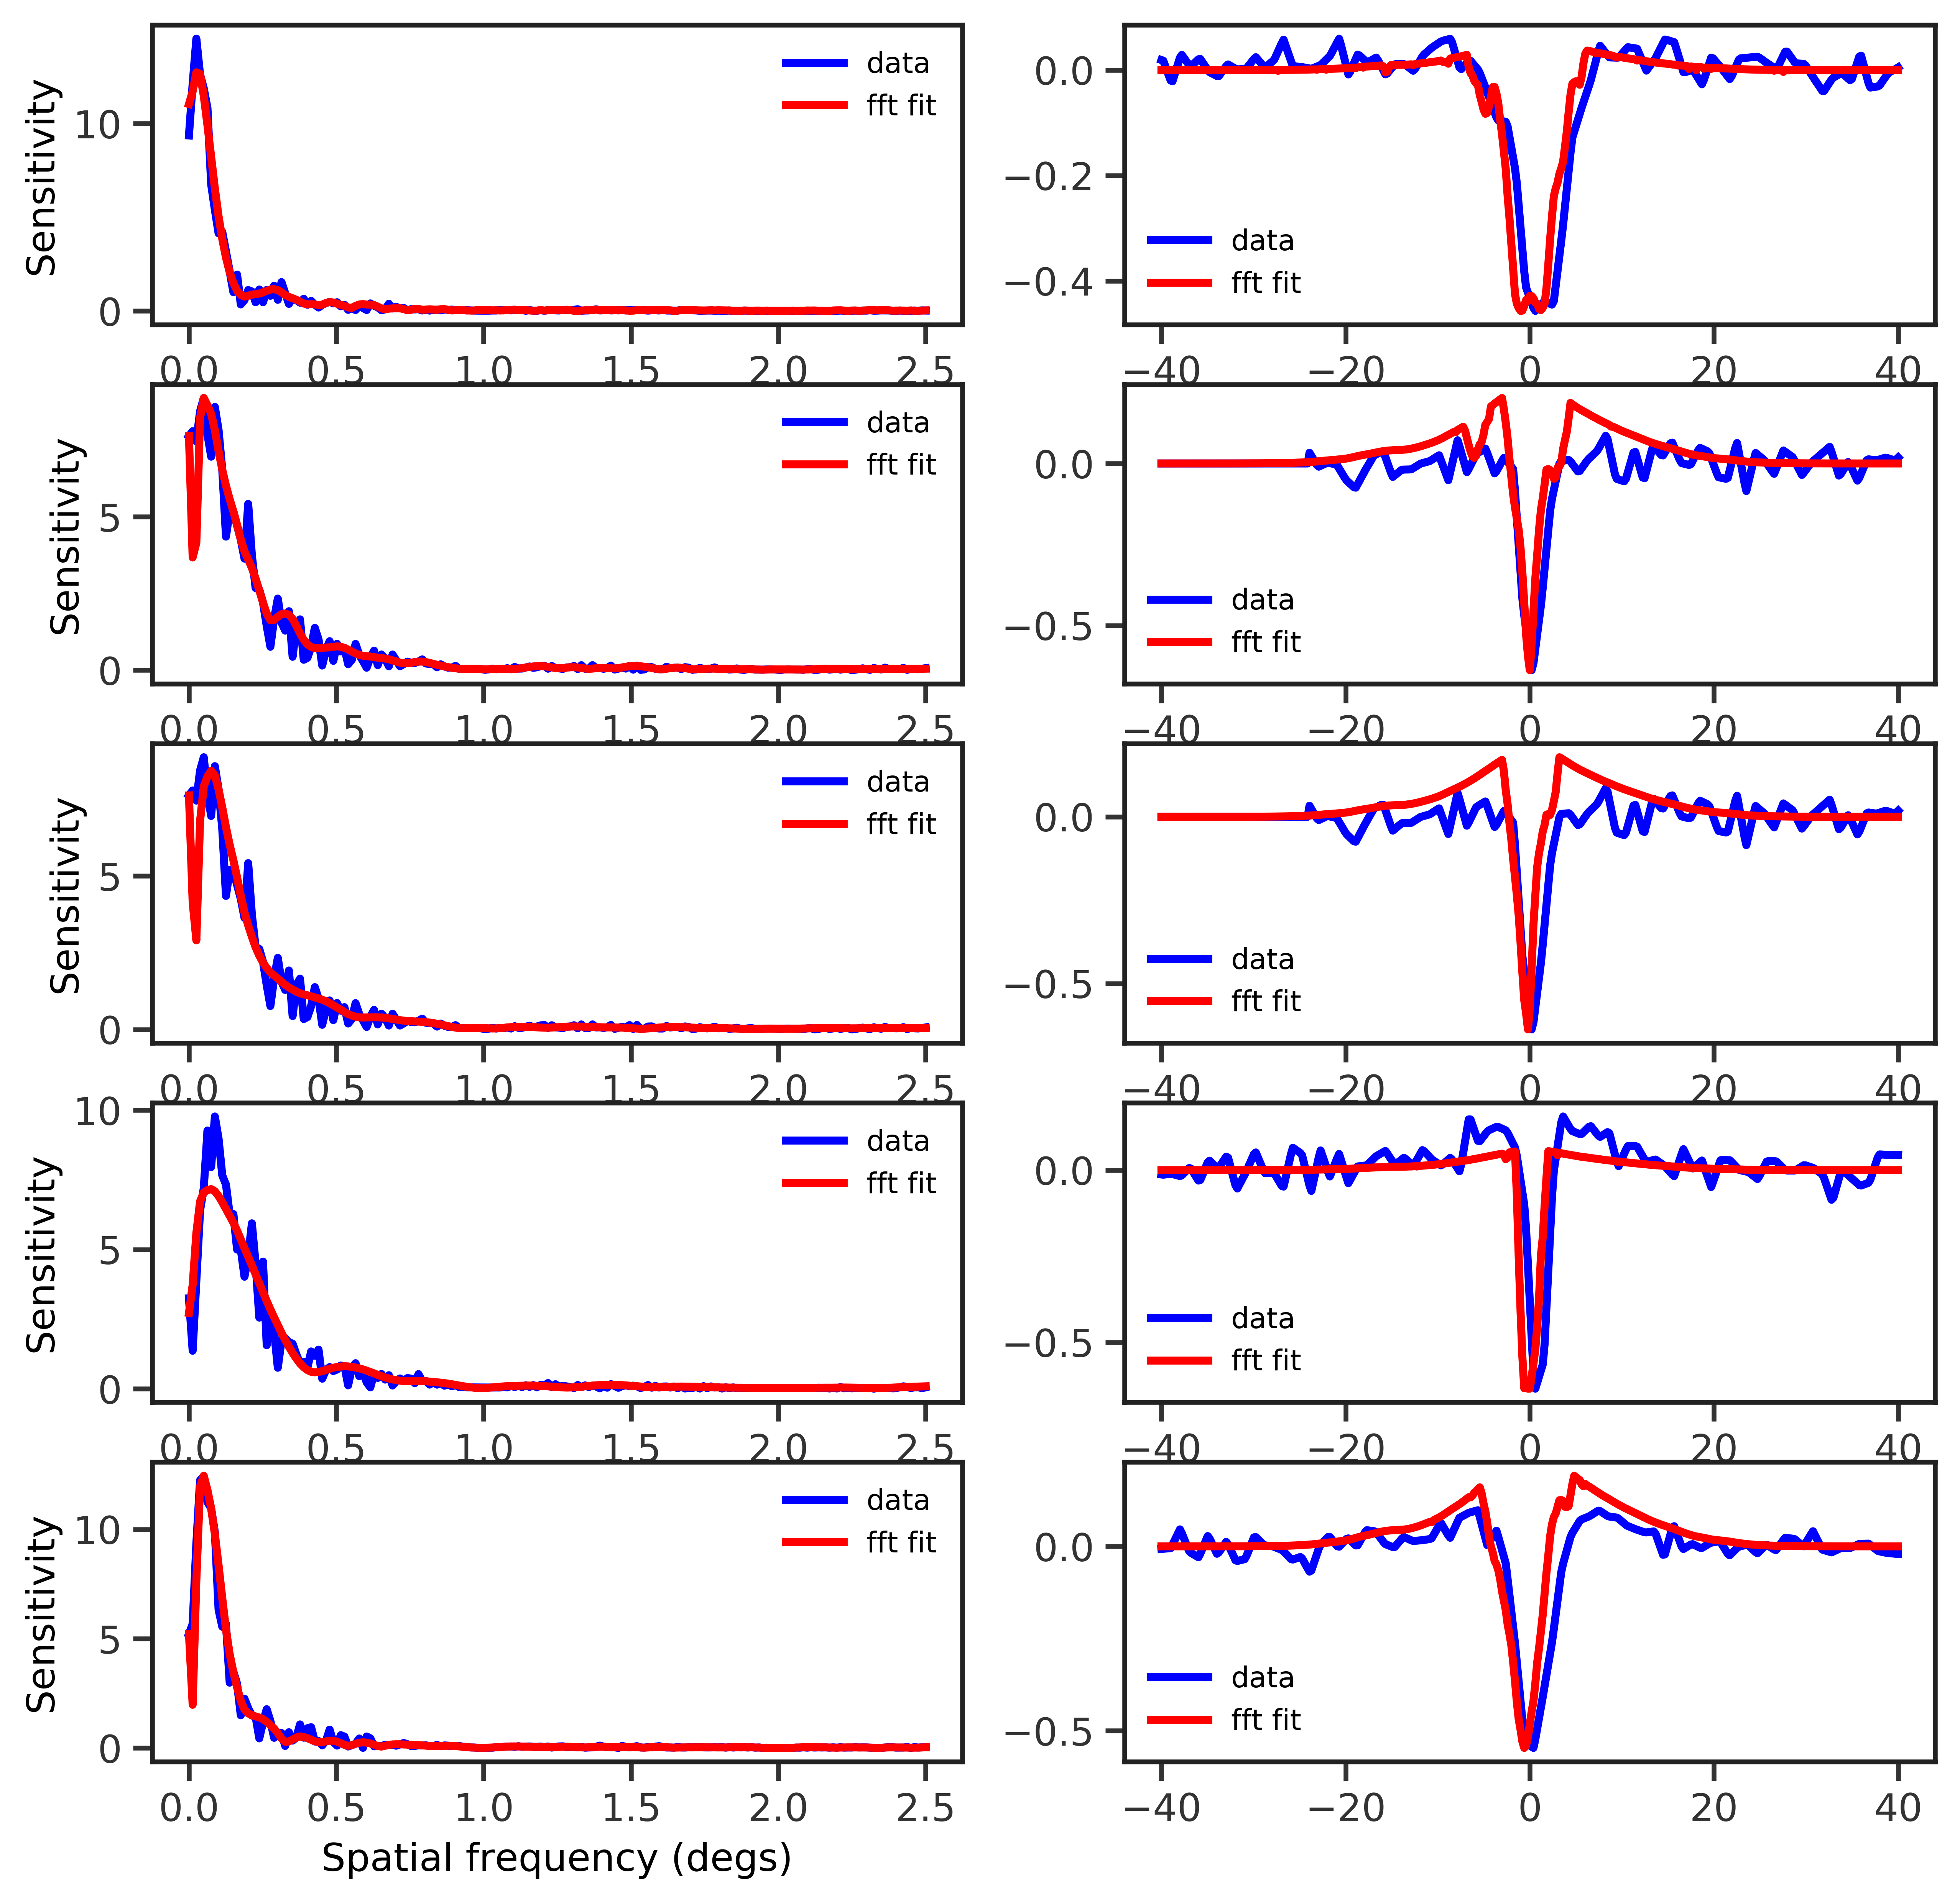

In [63]:
def rf_model(center, horz_weight, center_weight):
    # do the same transformation that happens in model_error_to_ganglion_cells
    center = np.where(center < 0, center, 0)
    center /= abs(np.sum(center))

    horz_weight = np.min([1.0, abs(horz_weight)])
    center_weight = np.min([1.0, abs(center_weight)])
    return center_weight*center + (1-center_weight)*(horz_weight*horz_pf + (1-horz_weight)*ama_pf)


fig = plt.gcf()
fig.set_size_inches((10,10))
celltype = 'medium_off_adapting'
count = 1
for idf, (hw, cw) in enumerate(fits_fft[celltype]):
    if (hw == 1.0) and (count <= 10):
        
        rf = receptive_fields[celltype][idf]
        modeled_rf = rf_model(fft_centers[celltype][idf], hw, cw)
        normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
        
        y = abs(np.fft.rfft(rf))
        y_hat = abs(np.fft.rfft(normed_rf))
        
        plt.subplot(5,2,count)
        plt.plot(freqs, y, 'b', label='data')
        plt.plot(freqs, y_hat, 'r', label='fft fit')
        plt.ylabel('Sensitivity')
        plt.xlabel('Spatial frequency (degs)')
        plt.legend(frameon=False, fontsize=9)
        count +=1
        
        plt.subplot(5,2,count)
        plt.plot(space, rf, 'b', label='data')
        plt.plot(space, normed_rf, 'r', label='fft fit')
        plt.legend(frameon=False, fontsize=9)
        count += 1

/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


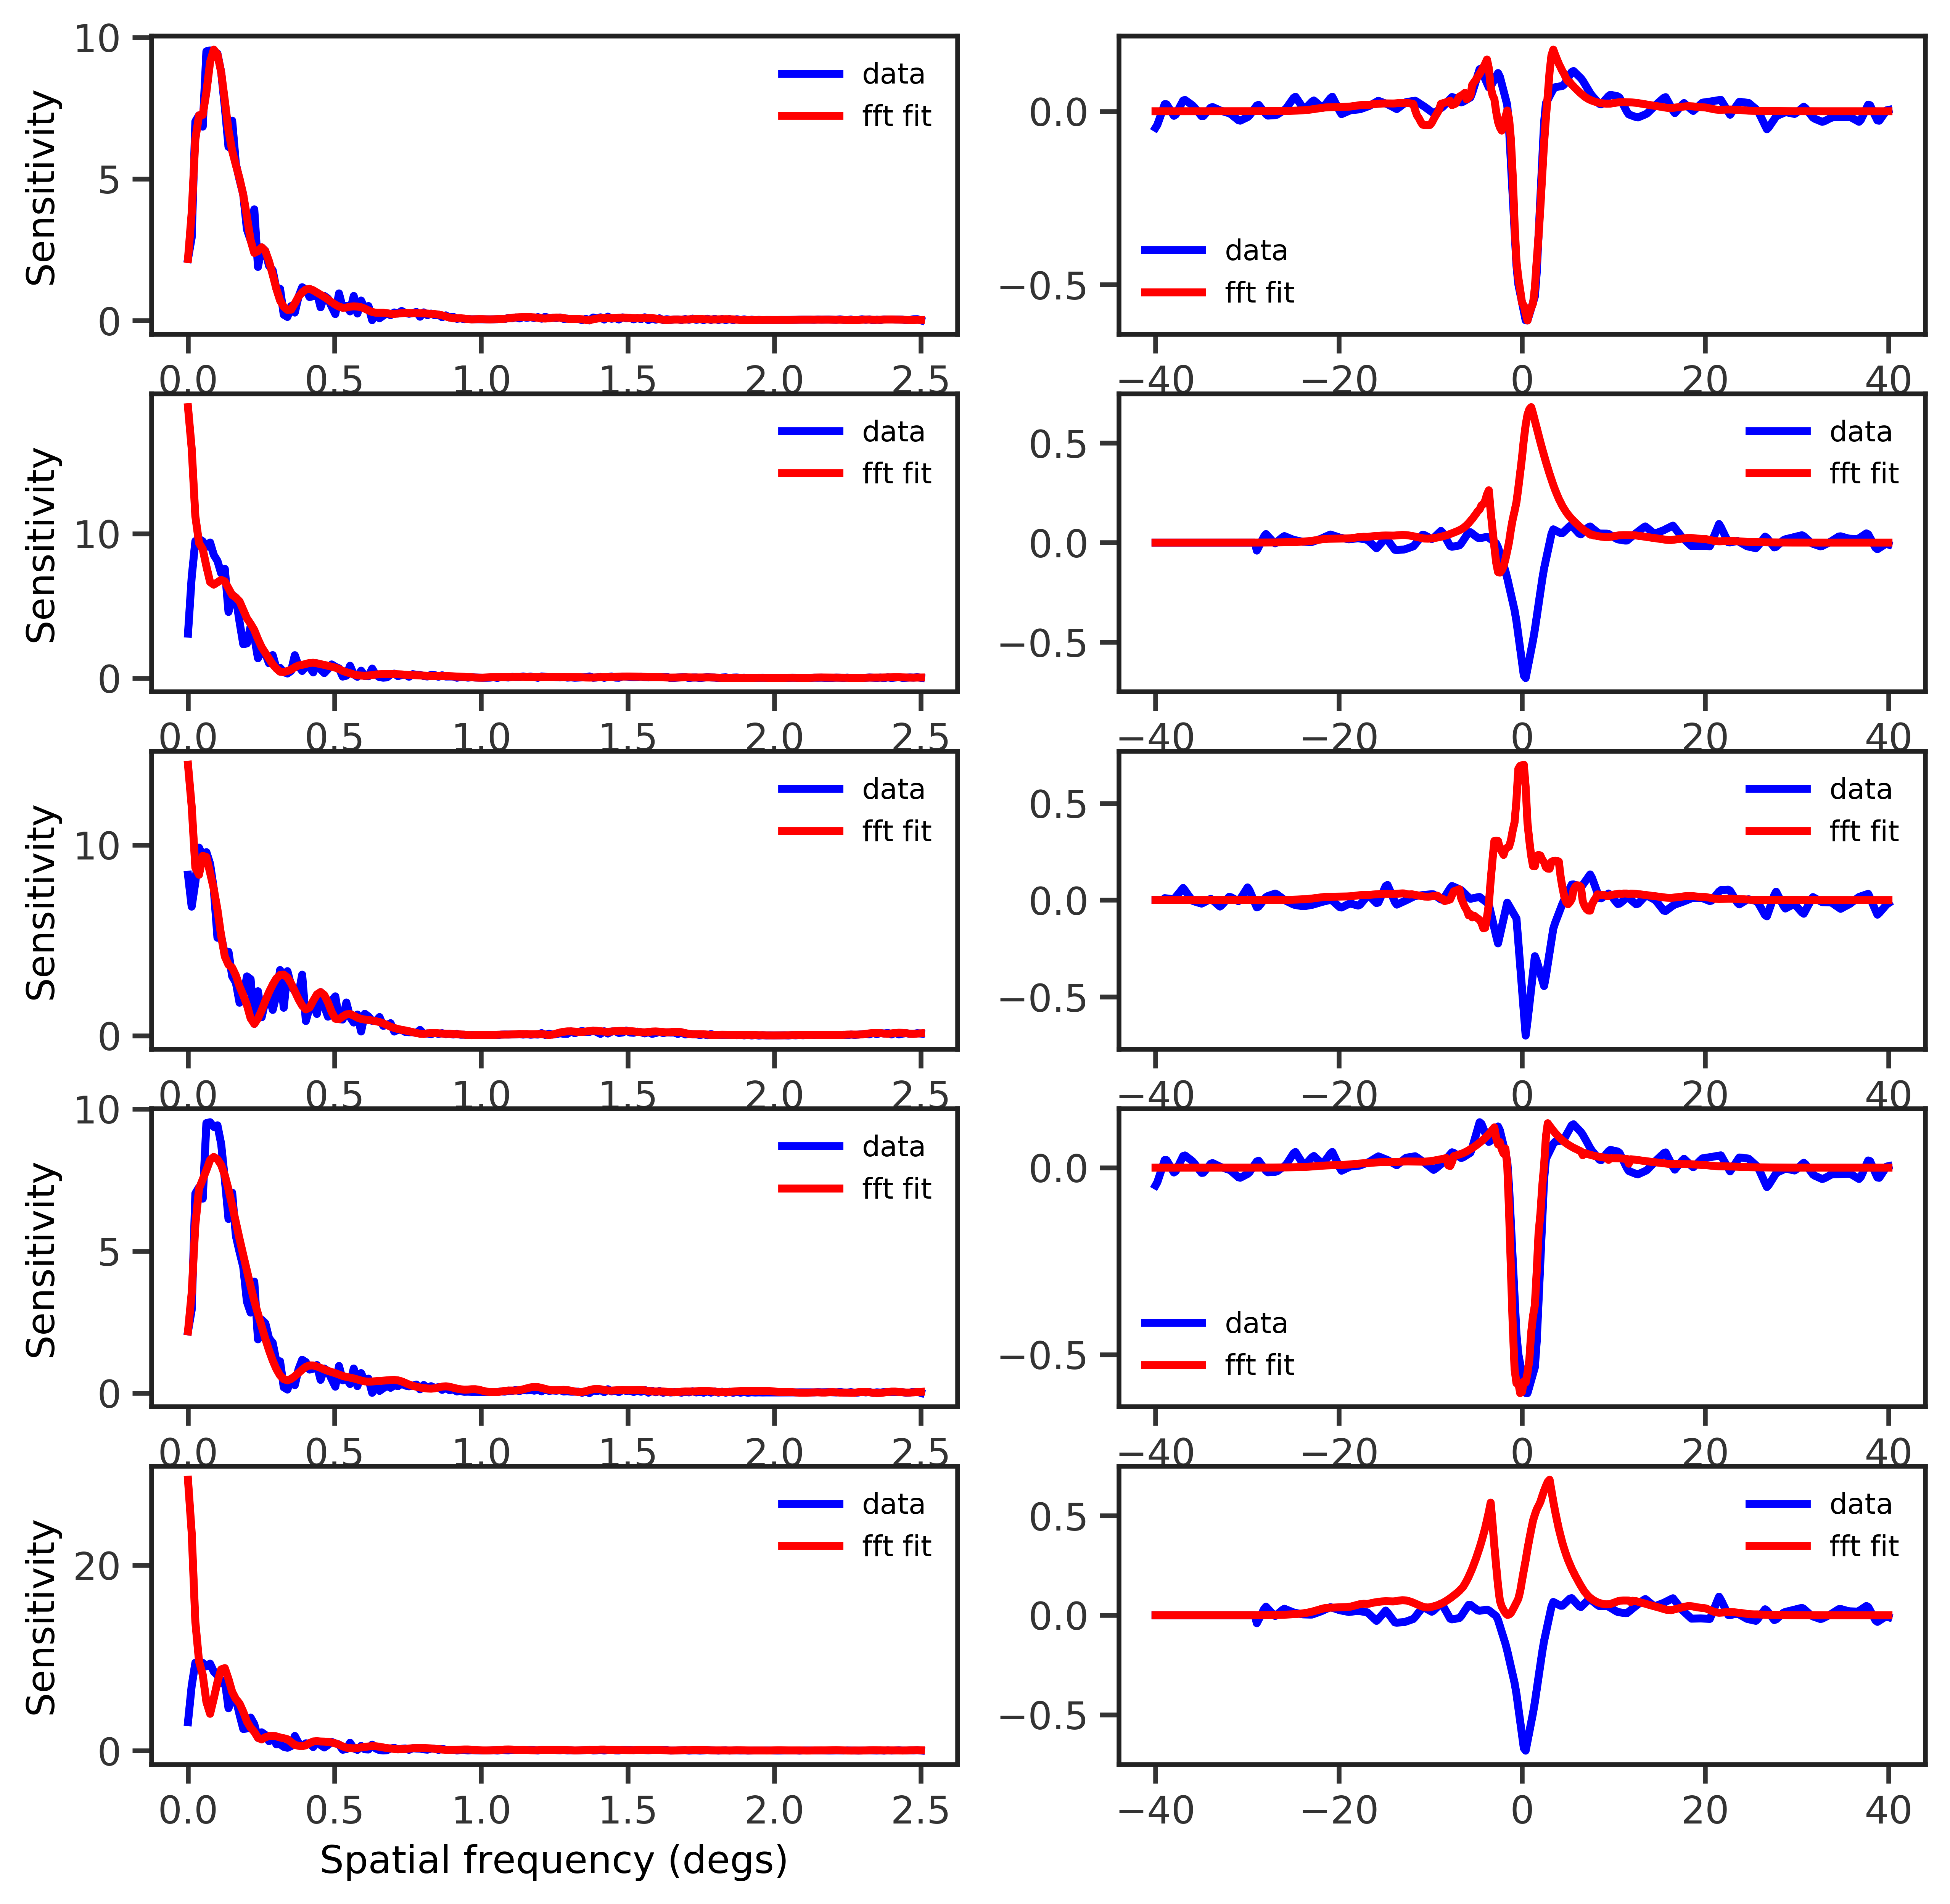

In [65]:
def rf_model(center, horz_weight, center_weight):
    # do the same transformation that happens in model_error_to_ganglion_cells
    center = np.where(center < 0, center, 0)
    center /= abs(np.sum(center))

    horz_weight = np.min([1.0, abs(horz_weight)])
    center_weight = np.min([1.0, abs(center_weight)])
    return center_weight*center + (1-center_weight)*(horz_weight*horz_pf + (1-horz_weight)*ama_pf)


fig = plt.gcf()
fig.set_size_inches((10,10))
celltype = 'medium_off_adapting'
count = 1
for idf, (hw, cw) in enumerate(fits_fft[celltype]):
    if (hw < 0.5) and (count <= 10):
        
        rf = receptive_fields[celltype][idf]
        modeled_rf = rf_model(fft_centers[celltype][idf], hw, cw)
        normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
        
        y = abs(np.fft.rfft(rf))
        y_hat = abs(np.fft.rfft(normed_rf))
        
        plt.subplot(5,2,count)
        plt.plot(freqs, y, 'b', label='data')
        plt.plot(freqs, y_hat, 'r', label='fft fit')
        plt.ylabel('Sensitivity')
        plt.xlabel('Spatial frequency (degs)')
        plt.legend(frameon=False, fontsize=9)
        count +=1
        
        plt.subplot(5,2,count)
        plt.plot(space, rf, 'b', label='data')
        plt.plot(space, normed_rf, 'r', label='fft fit')
        plt.legend(frameon=False, fontsize=9)
        count += 1